In [10]:
%run "/home/usriniva/uller_modified/discrete_time/Hanna_simu/simulation/impport_packages.ipynb"    #import all necessary packages - numpy, pandas etc
%run "/home/usriniva/uller_modified/discrete_time/Hanna_simu/simulation/simulation_class.ipynb"    #import all necessary packages - numpy, pandas etc
%run "/home/usriniva/uller_modified/discrete_time/Hanna_simu/simulation/create_world.ipynb"

### Reformulation

- Define the **maternal deviation**:


##### $\delta_t$= Phenotype of the mother - Genetic contribution of mother
##### $\delta_t$ = $P_{t-1} - G_{t-1}$

so that the phenotype is the sum of the genetic component of the current generation and maternal deviation from its phenotype:

$$
P = G_t + \omega * \delta_t + \varepsilon_{d}
$$

- We also separate mutation-related noise $\varepsilon_{m}$ from parental phenotype inheritance noise $\varepsilon_{epi}$.  
- We define a evolvable 'weight' term $\omega$: determines how much importance to give each term of the equation
- We also add developmental noise: purely environmental noise in teh form of  $\varepsilon_{d}$


The full new formulation becomes:

$$
Z' = (G_t + \varepsilon_{m}) + (\omega + \varepsilon_{epi})*(\delta_t) +  \varepsilon_{d}
$$

---

In [68]:
def run_simulation(args):
    env_param_space, popsize, maxgen, dims, N, mutsize, mutrate, epsilon, nof_dimensions, only_genetics = args
    
    rho_m_alpha_beta = env_param_space[0:4]
    env_states = env_param_space[4:]

    meanw = np.zeros(maxgen)
    meanmemory_g = np.zeros(maxgen)
    meanmemory_p= np.zeros(maxgen)
    meanneutral_g = np.zeros(maxgen)
    meanneutral_p = np.zeros(maxgen)
    mean_gen = np.zeros(maxgen)
    
    for t in range(0, (maxgen-1)):
        #if t%10 == 0:
        #    print(t)
        for d in range(0, nof_dimensions):
            N[:,dims['dev'][d]] = N[:,dims['pheno'][d]] - env_states[t]
            
        dev_combined = np.sqrt(np.sum(N[:,dims['dev']]**2, axis =1))     
        W = np.exp((-dev_combined**2)/ (2))
        
        
        meanw[t] = np.mean(W)    
        
        meanmemory_g[t] = np.mean(N[:, dims['memory']])  # the actual memory
        meanmemory_p[t] = np.mean(1/(1 + np.exp(-N[:,dims['memory']]))) #with the logistc correction
        
        meanneutral_g[t] = np.mean(N[:,dims['neutral']])
        meanneutral_p[t] = np.mean(1/(1 + np.exp(-N[:,dims['neutral']])))
        mean_gen[t] = np.mean(N[:,dims['geno']])
        
        
        #current gen offspring (the cube gets stored here per gen)
        
        offspring = np.zeros((popsize, dims['total_layers'])) # empty 3D matrix with dimensions of the cube
        
        #sample offspring for each scenario weighted by fitness
        
        
        parents_idx = np.random.choice(popsize, size=popsize, p = (W/np.sum(W)) )#pick #popsize sized random numbers
        offspring[:,:] = N[parents_idx, :] #similar to how it works in matlab
        
        mutate_memories = np.random.uniform(low=0, high=1, size= popsize) < mutrate[0]
        #mutate_neutral = np.random.uniform(low=0, high=1, size=popsize) < mutrate[0]
        mutate_geno = np.random.uniform(low=0, high=1, size=(popsize, nof_dimensions)) < mutrate[1]
        
        # adding a mutation of size mutsize[1], rate mutate_memories, to the epi-memory
        # the epignetic memory evolves; 
        
        offspring[:,dims['memory']] = (
                                offspring[:,dims['memory']] 
                                + mutate_memories * np.random.normal(0, mutsize[0], popsize)
        )
        
        # adding a mutation of size mutsize[1] (epi-mutation size), rate mutate_memories, to the neutral phenotype
        # the neutral trait recieves random mutation but is not implemented in the calculation for fitness; so is evolving neutrally
        offspring[:,dims['neutral']] = (
                                offspring[:,dims['neutral']]  
                                + mutate_memories * np.random.normal(0, mutsize[0], popsize)
        ) 
        
        # adding a mutation of size mutsize[2] (genetic mutation size), rate mutate_memories, to the genotype

        offspring[:,dims['geno']] = (
                            offspring[:,dims['geno']] 
                            + mutate_geno * np.random.normal(0, mutsize[1], size=(popsize, nof_dimensions) )
        )
        
        if only_genetics :
            if t % 10000 == 0:
                print(f"Gen {t}: Running ONLY genetics mode")
            
            for i in range(0, nof_dimensions):
                offspring[:, dims['pheno'][i]] = (
                offspring[:, dims['geno'][i]]
                + np.random.normal(0, epsilon, size=popsize) )
        else:
            if t % 1000 == 0:
                print(f"Gen {t}: Running EPIGENETIC mode")
            
            for i in range(0, nof_dimensions):
                    offspring[:, dims['pheno'][i]] = (
                        offspring[:, dims['geno'][i]] #genotype
                        + np.random.normal(0, epsilon, size=popsize) # adding random noise (developemental noise, nromally distributed with epsilon variance)
                        + ((1 / (1 + np.exp(-offspring[:, dims['memory']]))) #phenotype version of the memory (y axis) 
                        * (N[parents_idx, dims['pheno'][i]] - N[parents_idx, dims['geno'][i]]))# adding the deviation -> read as weight (phenotypic component * deviation)
                    )
        N = offspring
        
        
    return {                ## Make sure this is indented!!
        'maxgen_popsize': [maxgen,popsize],
        'rho_m_alpha_beta' :rho_m_alpha_beta,
        'meanw': meanw,
        'meanmemory_g': meanmemory_g,
        'meanmemory_p': meanmemory_p,
        'meanneutral_g': meanneutral_g,
        'meanneutral_p': meanneutral_p,
        'mean_geno': mean_gen
        }
        
        

In [69]:
rho_cases = 20
m_cases= 20
maxgen= 10000


full_env_values = create_world(rho_cases, m_cases, maxgen)   # create world (input: generations, no. rhos and no. ms) 
print(full_env_values.shape)

clean_data_env = full_env_values[~np.isnan(full_env_values).any(axis=1)]

(400, 10004)


In [70]:

nof_scenarios = np.shape(clean_data_env)[0]
print('nof_scenarios:', nof_scenarios) 

rho_m_alpha_beta = clean_data_env[0:4]
env_states = clean_data_env[4:]


nof_scenarios: 291


In [71]:


popsize = 2500

# Mutation rates: [epi-memory mutation rate, geno mutation rate]
mutrate = [0.0001, 0.0001]

# Mutation sizes: [epi-memory mutation size, geno mutation size]
mutsize = [1, 1]

epsilon = 0.05 # phenotypic noise
                                 
initial_memory = 3


 mutrate = [0.0001, 0.0001] seems to produce mutation sizes that are good enouhgh for for attaining high values and not fluctuating a lot because of too much highness

In [6]:
mutrate[0]*mutsize[0]

0.0001

In [ ]:
results_array = {}  

# Number of dimensions (can be 1 or more)
nof_dimensions = 5

# get the cube dimensions
dims = get_cube_dims(nof_dimensions)

#create the cube
N = create_cube(popsize, dims=dims, nof_dimensions=nof_dimensions, epsilon=epsilon, initial_memory=initial_memory)

print(N.shape)

if __name__ == '__main__':
    
    # Create all combinations of sigma_mut and sigma_alpha
    param_grid = [
        (scenario, popsize, maxgen, dims, N, mutsize, mutrate, epsilon, nof_dimensions, False) #only genetics can either be True or false
        for _, scenario in enumerate(clean_data_env) #where each row corresponds to one scenario
    ]

    num_cpus = 10
    
    with concurrent.futures.ProcessPoolExecutor(num_cpus) as executor:
        name = f'results_array_{nof_dimensions}' 
        results_array[name] = list(executor.map(run_simulation, param_grid))
print(N.shape)




(2500, 17)
Gen 0: Running EPIGENETIC modeGen 0: Running EPIGENETIC mode
Gen 0: Running EPIGENETIC mode
Gen 0: Running EPIGENETIC mode

Gen 0: Running EPIGENETIC mode
Gen 0: Running EPIGENETIC modeGen 0: Running EPIGENETIC modeGen 0: Running EPIGENETIC mode
Gen 0: Running EPIGENETIC mode


Gen 0: Running EPIGENETIC mode
Gen 1000: Running EPIGENETIC mode
Gen 1000: Running EPIGENETIC mode
Gen 1000: Running EPIGENETIC mode
Gen 1000: Running EPIGENETIC mode
Gen 1000: Running EPIGENETIC mode
Gen 1000: Running EPIGENETIC mode
Gen 1000: Running EPIGENETIC mode
Gen 1000: Running EPIGENETIC mode
Gen 1000: Running EPIGENETIC mode
Gen 1000: Running EPIGENETIC mode
Gen 2000: Running EPIGENETIC mode
Gen 2000: Running EPIGENETIC mode
Gen 3000: Running EPIGENETIC mode
Gen 2000: Running EPIGENETIC mode
Gen 2000: Running EPIGENETIC mode
Gen 2000: Running EPIGENETIC mode
Gen 3000: Running EPIGENETIC mode
Gen 2000: Running EPIGENETIC mode
Gen 2000: Running EPIGENETIC mode
Gen 2000: Running EPIGENETIC mode

THINK BEFORE RUNNING BELOW!!!!

In [ ]:
#file='/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/long_time/gens10k_0.0001mutrate_0start.pkl'

#with open(file, 'wb') as f:
    #pickle.dump(results_array, f)

In [27]:
with open(file, "rb") as file:
            results_array = pickle.load(file)

In [220]:
folder_path='/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/long_time/'

# Choose start folder based on initial_memory
if initial_memory == -3:
    start = 'start-3'
elif initial_memory == 0:
    start = 'start0'
elif initial_memory == 3:
    start = 'start3'
else:
    raise ValueError(f"Unexpected initial_memory value: {initial_memory}")

# Build filename and full path
#filename = f'gens{maxgen}_start{initial_memory}_dims{nof_dimensions}_onlygen.pkl'
filename = f'gens{maxgen}_start{initial_memory}_dims{nof_dimensions}.pkl'
full_path = os.path.join(folder_path, start, filename)

# Save file
with open(full_path, 'wb') as f:
    pickle.dump(results_array, f)


OKAY TO RUN THIS!!

In [51]:
dim_objnames_epi = {}
folder_path = '/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/long_time/start-3/epi'
for i, filename in enumerate(sorted(os.listdir(folder_path))):
    if filename.endswith(".pkl"):
        
        file_path = os.path.join(folder_path, filename)
        print(f"Loading: {filename}")
        
        # Load the pickle file
        with open(file_path, "rb") as file:
            data = pickle.load(file)
            
        nof_dims = re.search(r'_dims(\d+)', filename).group(1)

        
        name= f'epi_{nof_dims}'
        dim_objnames_epi[name] = data
        
        print(f"Loaded {filename} into {name}")
        
dim_objnames_onlygen = {}
folder_path = '/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/long_time/start-3/onlygen'
for i, filename in enumerate(sorted(os.listdir(folder_path))):
    if filename.endswith(".pkl"):
        
        file_path = os.path.join(folder_path, filename)
        print(f"Loading: {filename}")
        
        # Load the pickle file
        with open(file_path, "rb") as file:
            data = pickle.load(file)
            
        nof_dims = re.search(r'_dims(\d+)', filename).group(1)

        
        name= f'onlygen_{nof_dims}'
        dim_objnames_onlygen[name] = data
        
        print(f"Loaded {filename} into {name}")

Loading: gens10000_start-3.0_dims1.pkl
Loaded gens10000_start-3.0_dims1.pkl into epi_1
Loading: gens10000_start-3.0_dims10.pkl
Loaded gens10000_start-3.0_dims10.pkl into epi_10
Loading: gens10000_start-3.0_dims5.pkl
Loaded gens10000_start-3.0_dims5.pkl into epi_5
Loading: gens10000_start-3.0_dims10_onlygen.pkl
Loaded gens10000_start-3.0_dims10_onlygen.pkl into onlygen_10
Loading: gens10000_start-3.0_dims1_onlygen.pkl
Loaded gens10000_start-3.0_dims1_onlygen.pkl into onlygen_1
Loading: gens10000_start-3.0_dims5_onlygen.pkl
Loaded gens10000_start-3.0_dims5_onlygen.pkl into onlygen_5


In [3]:
sorted_epi_keys = sorted(dim_objnames_epi.keys(), key=lambda x: int(re.findall(r'\d+', x)[0]))
sorted_og_keys = sorted(dim_objnames_onlygen.keys(), key=lambda x: int(re.findall(r'\d+', x)[0]))
# Get all keys 
keys = dim_objnames_epi[sorted_epi_keys[0]]['results_array_1'][0].keys()
keys

dict_keys(['maxgen_popsize', 'rho_m_alpha_beta', 'meanw', 'meanmemory_g', 'meanmemory_p', 'meanneutral_g', 'meanneutral_p'])

/tmp/ipykernel_31521/2396579899.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("spring")


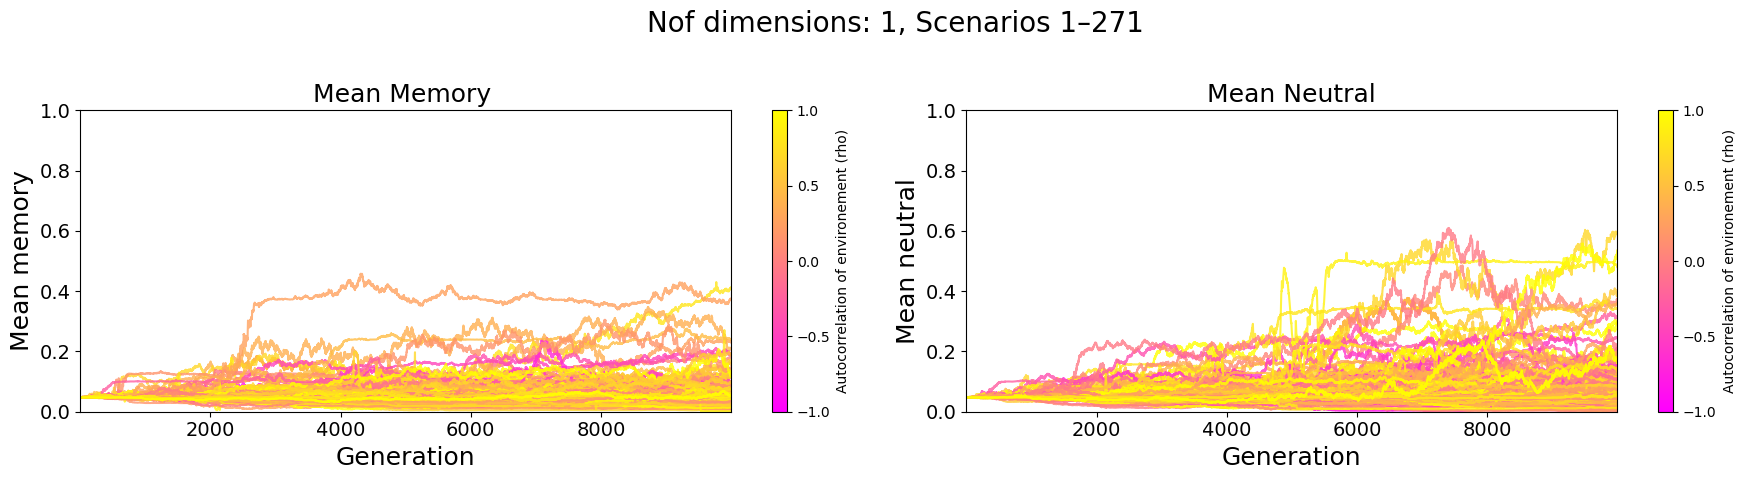

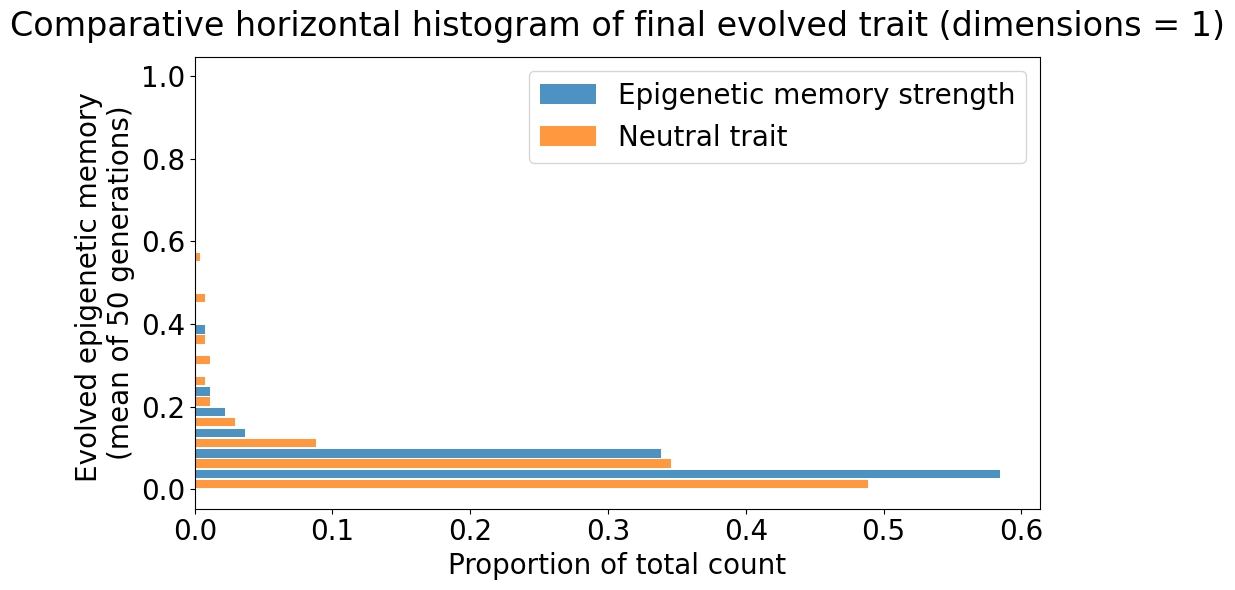

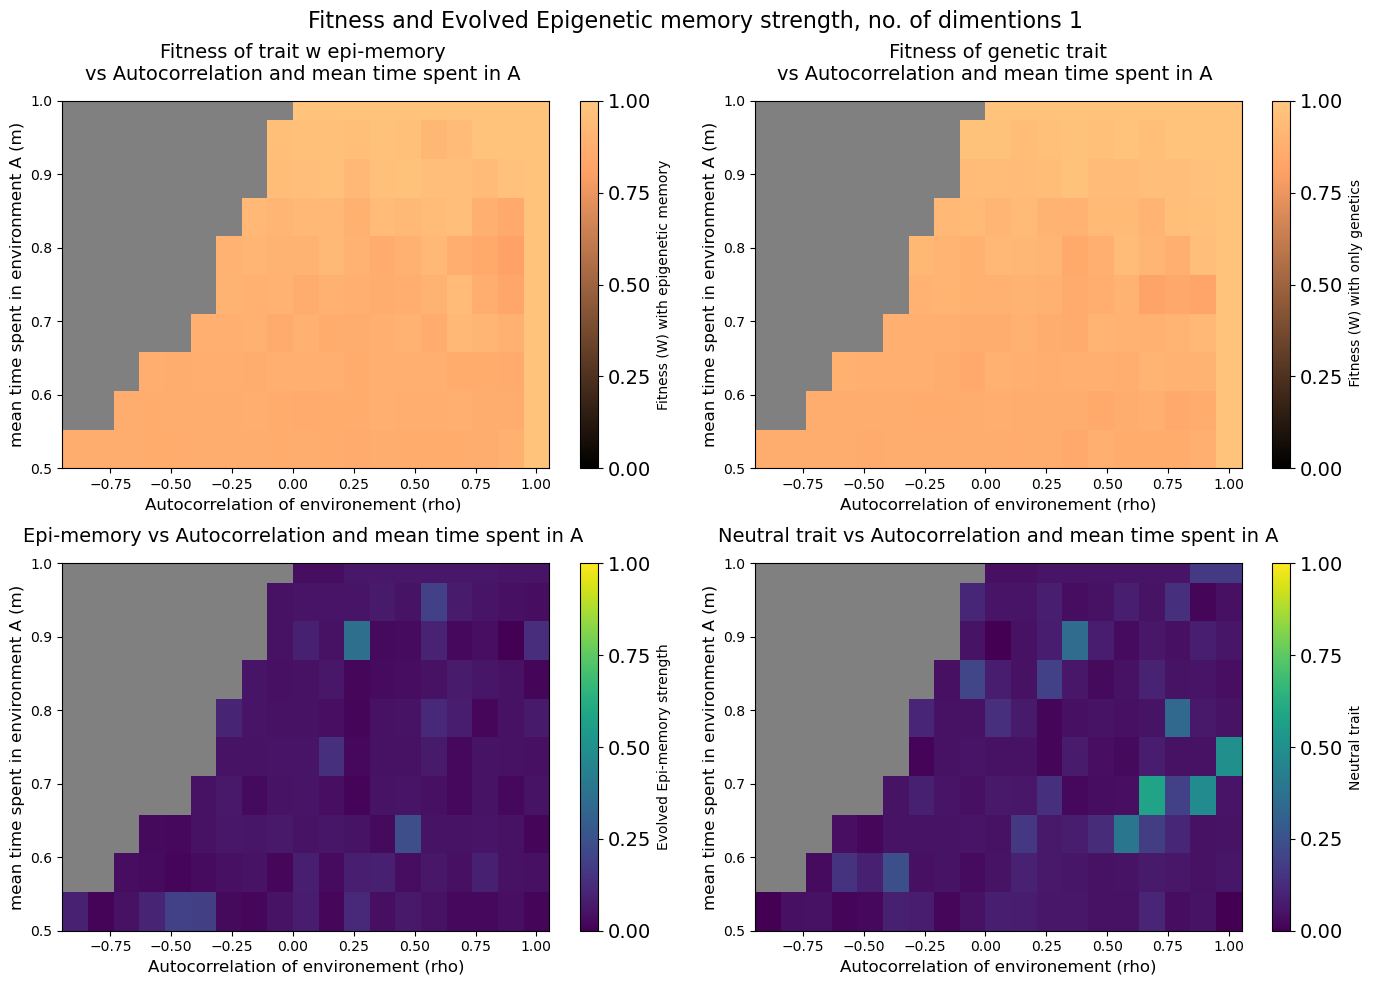

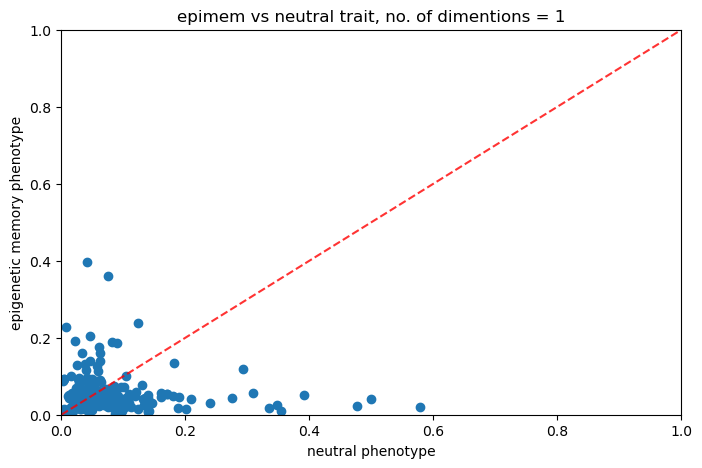

/tmp/ipykernel_31521/2396579899.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("spring")


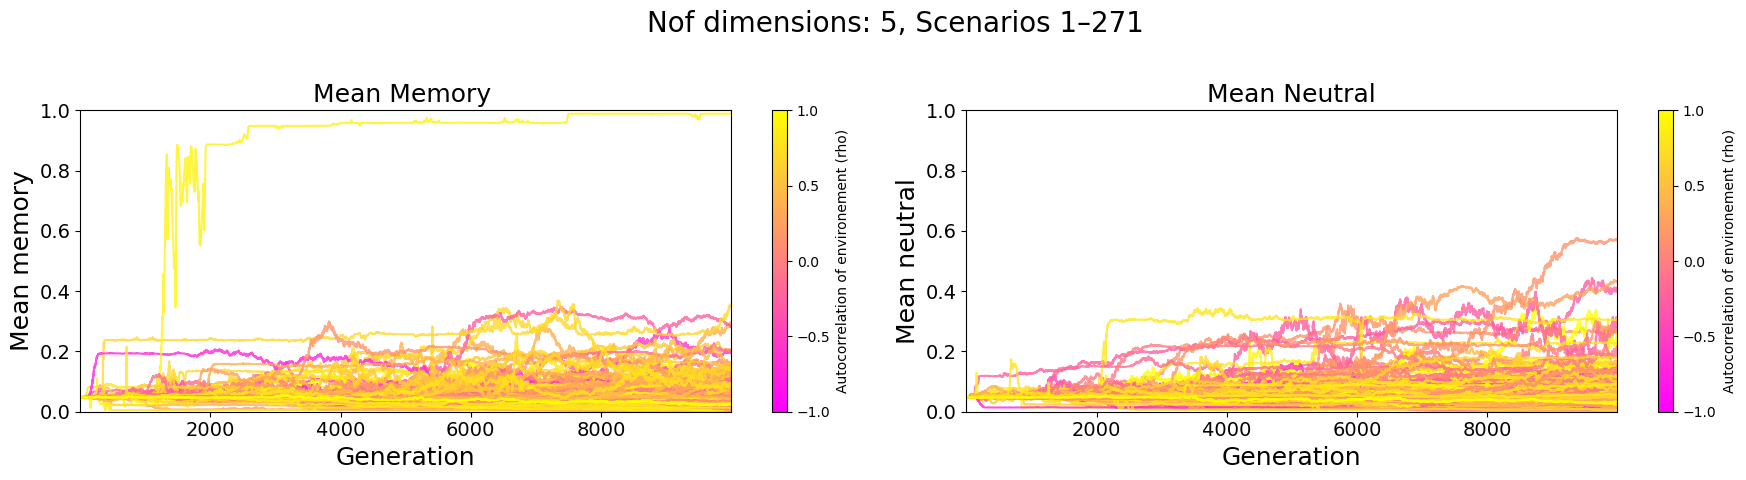

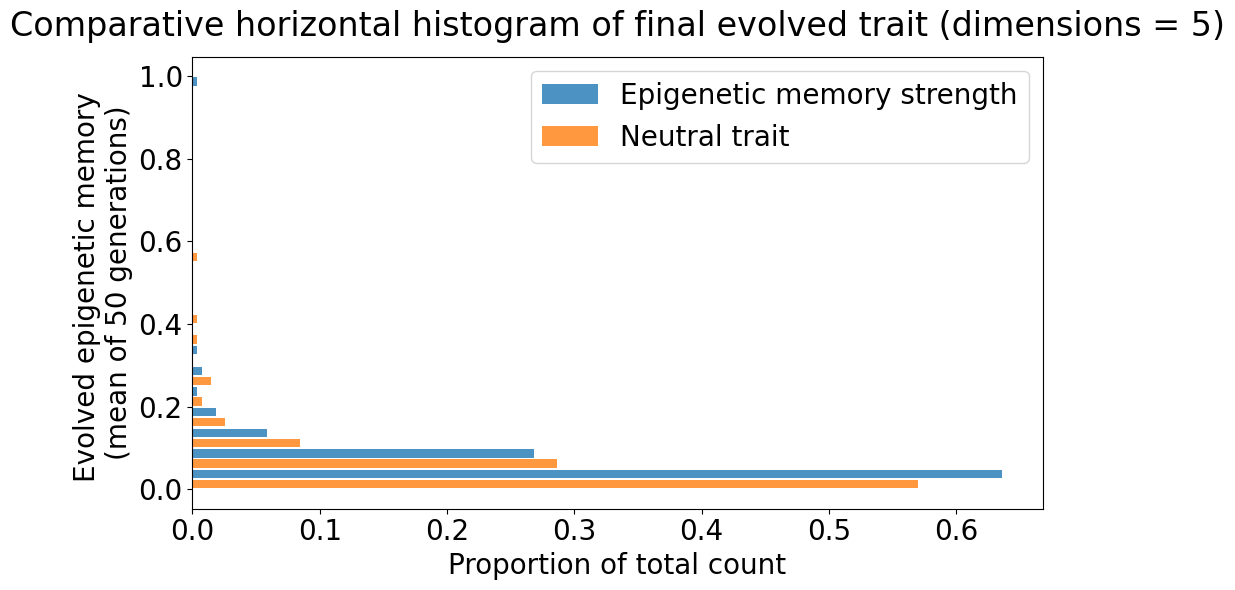

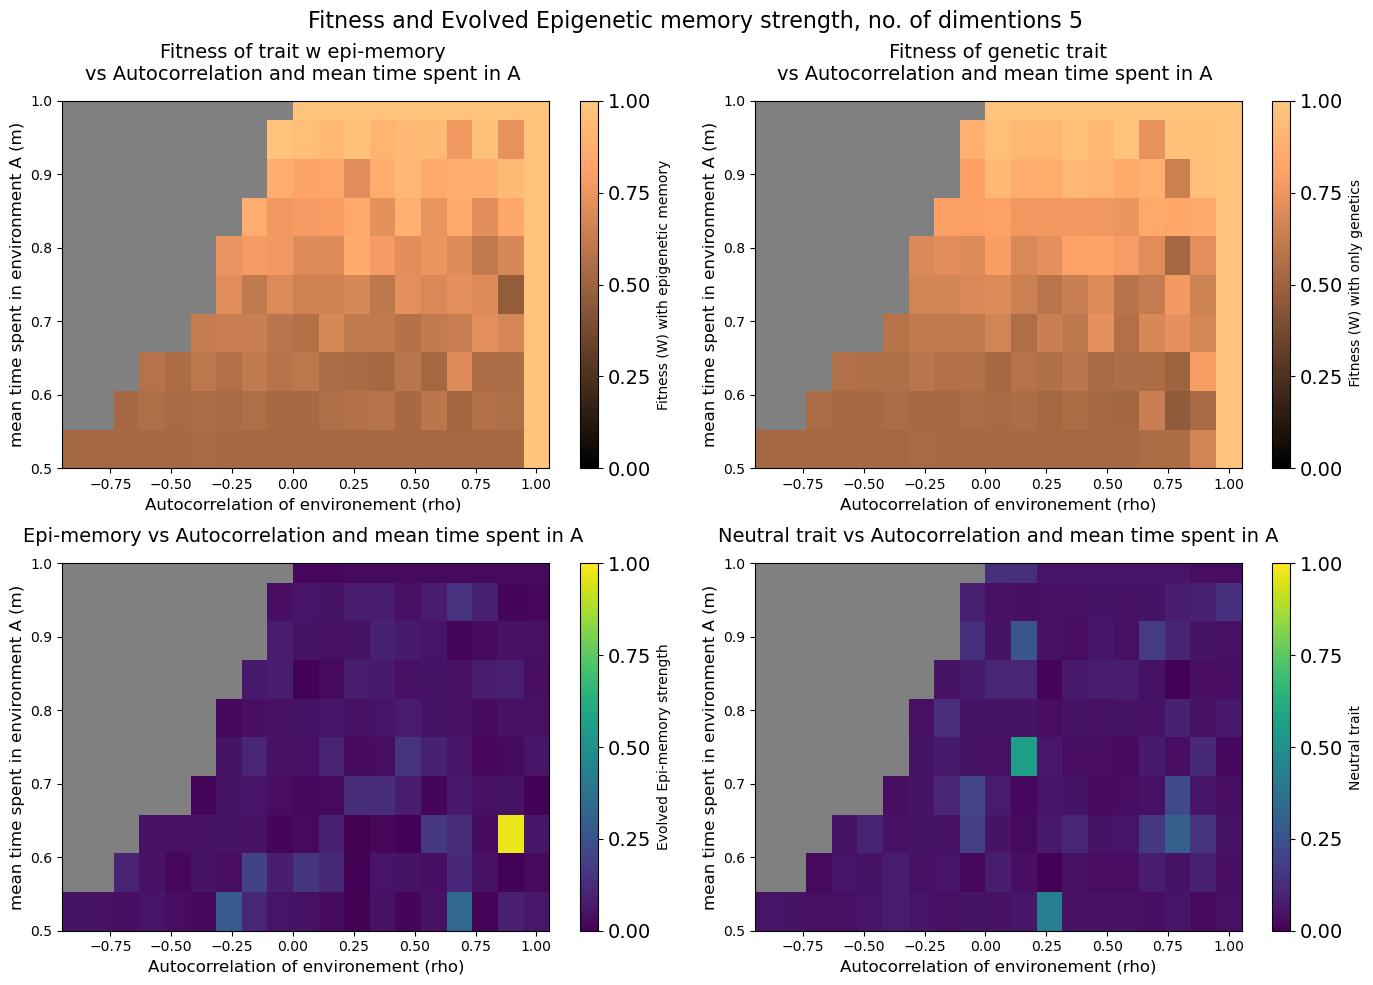

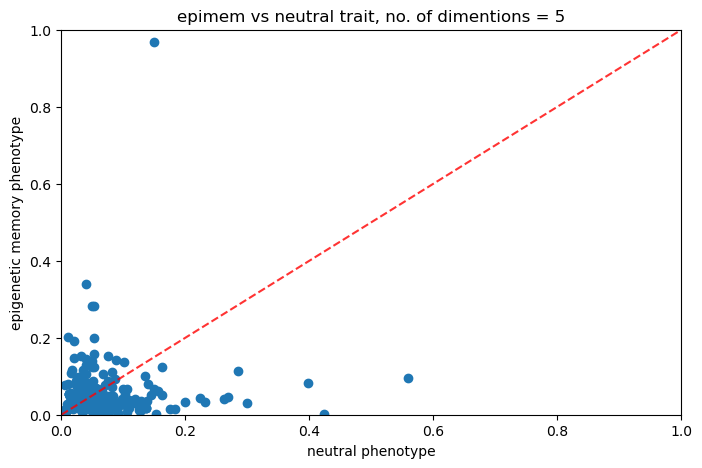

/tmp/ipykernel_31521/2396579899.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("spring")


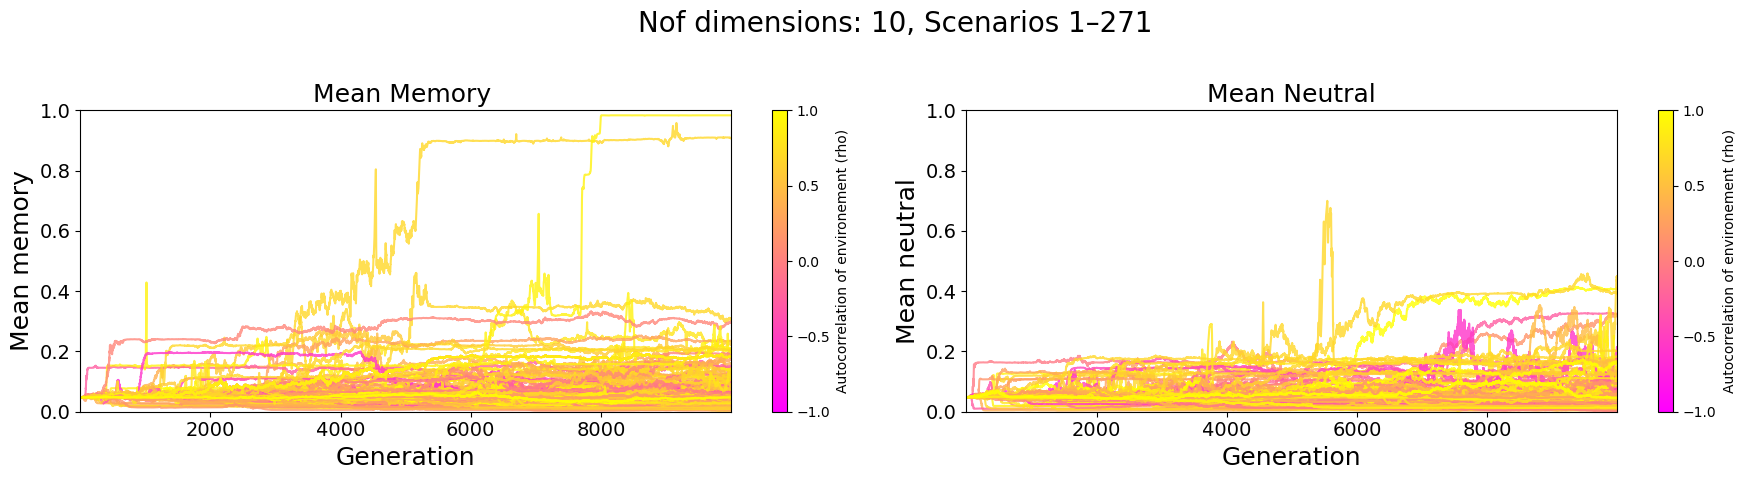

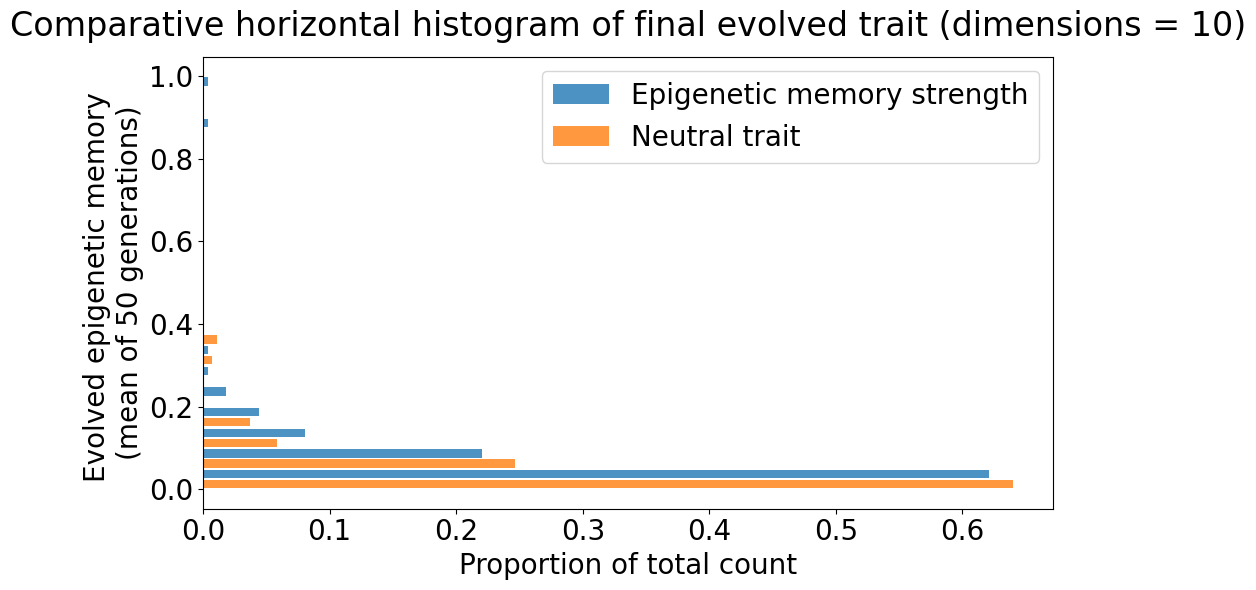

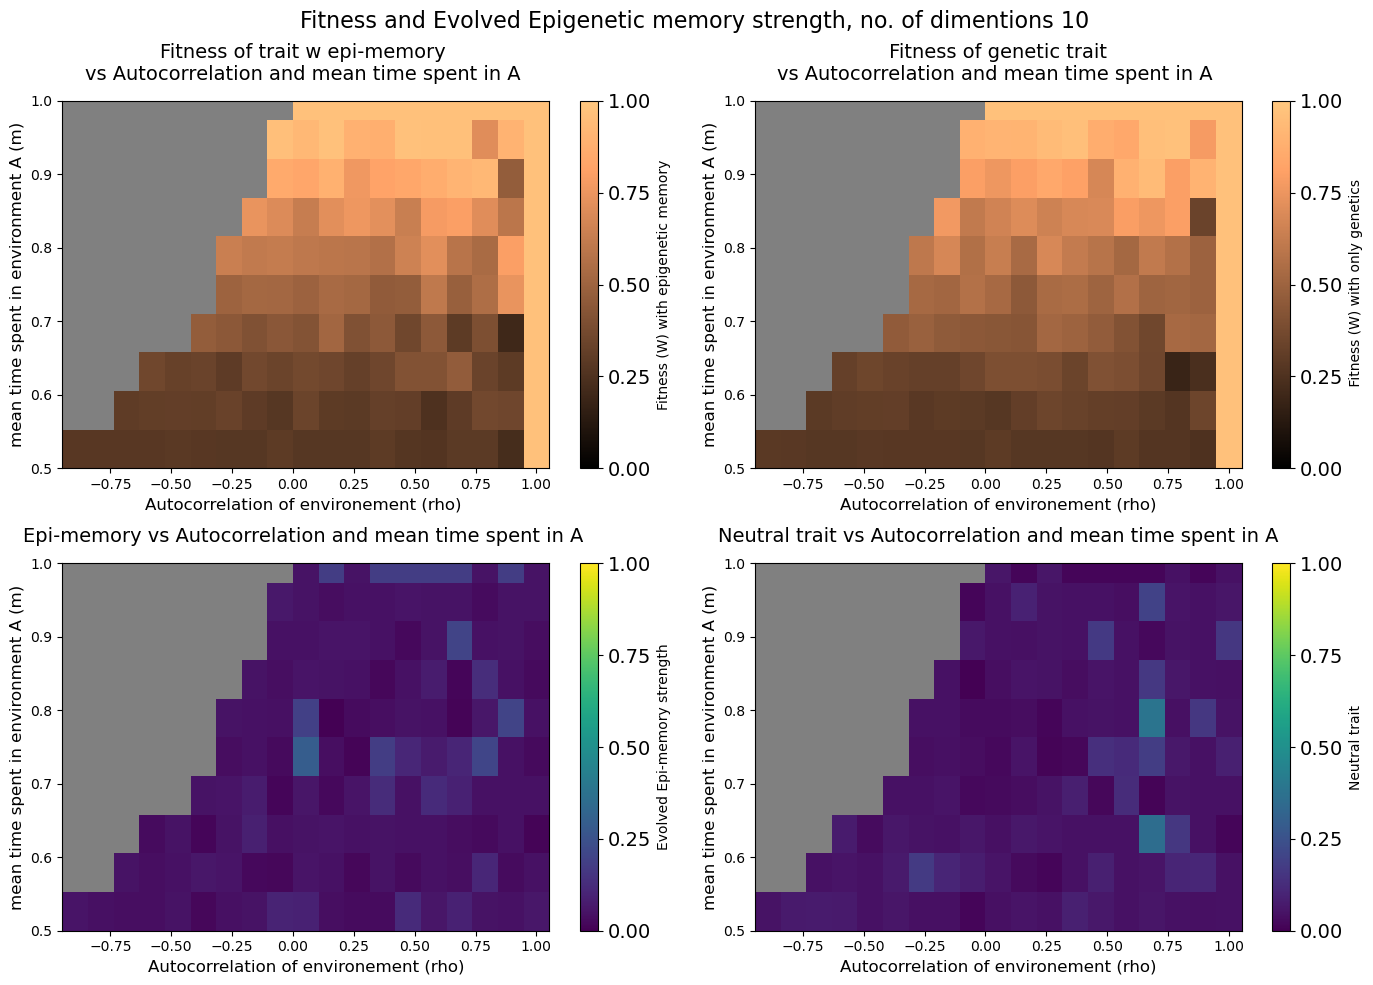

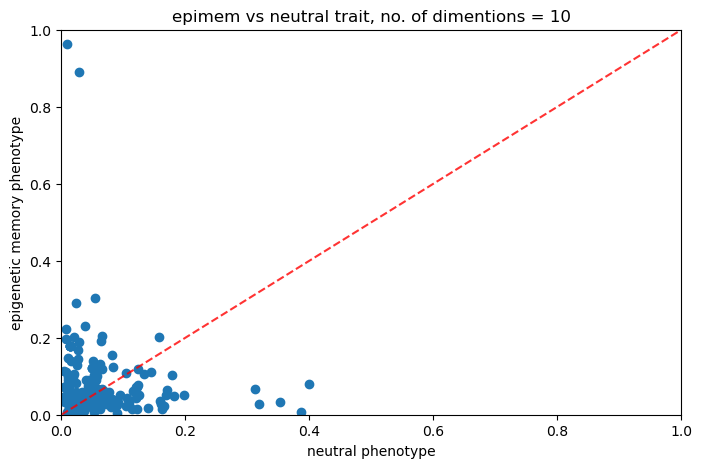

In [52]:
start = 1
concatenated_results_epi = {}
concatenated_results_gen = {}

for array_epi, array_gen in zip(sorted_epi_keys, sorted_og_keys):
    
    nof_dims = re.findall(r'\d+', array_epi)[0]
    
    
    array_name_epi = next(iter(dim_objnames_epi[array_epi].keys()))
    array_name_gen = next(iter(dim_objnames_onlygen[array_gen].keys()))

    
    
    for k in keys:
        concatenated_results_epi[k] = np.vstack([r[k] for r in dim_objnames_epi[array_epi][array_name_epi]])
        
    for k in keys:
        concatenated_results_gen[k] = np.vstack([r[k] for r in dim_objnames_onlygen[array_gen][array_name_gen]])
        
    # Extract variables
    data = concatenated_results_epi
    data_gen = concatenated_results_gen
    
    
    meanmemory_p = data['meanmemory_p'][:, :-1]
    meanneutral_p = data['meanneutral_p'][:, :-1]


    nof_scenarios = meanmemory_p.shape[0]
    maxgen = meanmemory_p.shape[1]

        # Extract rho for each scenario
    rho_values = data['rho_m_alpha_beta'][:, 0]   # one rho per scenario

    # Create figure
    fig, ax = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

    # Normalize rho range → [0, 1]
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    cmap = cm.get_cmap("spring")

    # Loop over scenarios
    for i in range(start, nof_scenarios):
        rho = rho_values[i]           # pick rho for this scenario
        color = cmap(norm(rho))       # convert rho → color

        ax[0].plot(meanmemory_p[i, :], color=color, alpha=0.8)
        ax[1].plot(meanneutral_p[i, :], color=color, alpha=0.8)

    # Axis formatting
    ax[0].set_title("Mean Memory ", fontsize=18)
    ax[0].set_ylabel("Mean memory", fontsize=18)
    ax[0].set_xlabel("Generation",  fontsize=18)
    ax[0].set_xlim(1, maxgen)
    ax[0].set_ylim(0, 1)

    ax[1].set_title("Mean Neutral", fontsize=18)
    ax[1].set_ylabel("Mean neutral",  fontsize=18)
    ax[1].set_xlabel("Generation", fontsize=18)
    ax[1].set_xlim(1, maxgen)
    ax[1].set_ylim(0, 1)
    ax[0].tick_params(axis='both', labelsize=14)
    ax[1].tick_params(axis='both', labelsize=14)
    
    #  Add a colorbar based on rho values
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # required
    cbar = fig.colorbar(sm, ax=ax[0], label="Autocorrelation of environement (rho)", ticks=[-1, -0.5, 0,  0.5,  1.0])
    cbar = fig.colorbar(sm, ax=ax[1], label="Autocorrelation of environement (rho)", ticks=[-1, -0.5, 0,  0.5,  1.0])
    fig.suptitle(f"Nof dimensions: {nof_dims}, Scenarios {start}–{nof_scenarios - 1}", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    ##########
 
    rho_ext, m_ext = np.meshgrid(data['rho_m_alpha_beta'][:,0],data['rho_m_alpha_beta'][:,1])

    df = pd.DataFrame({
        
    'rho': data['rho_m_alpha_beta'][:,0],
    'm': data['rho_m_alpha_beta'][:,1],
    'fitness':np.mean(data['meanw'][:,-50:], axis=1),
    'epi_mem_p': np.mean(data['meanmemory_p'][:,-50:], axis=1),
    'neutral_trait_p' : np.mean(data['meanneutral_p'][:,-50:], axis=1 )
    })
    
    df_gen = pd.DataFrame({
        
    'rho': data_gen['rho_m_alpha_beta'][:,0],
    'm': data_gen['rho_m_alpha_beta'][:,1],
    'fitness':np.mean(data_gen['meanw'][:,-50:], axis=1)
    })
    


    # Extract the two traits
    epi = df['epi_mem_p']
    neu = df['neutral_trait_p']

    # Define discrete bins
    bins = np.linspace(0, 1, 21)   # 20 bins
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Compute counts
    counts_epi, _ = np.histogram(epi, bins=bins)
    counts_neu, _ = np.histogram(neu, bins=bins)

    # Convert to frequencies
    freq_epi = counts_epi / counts_epi.sum()
    freq_neu = counts_neu / counts_neu.sum()

    # Width of each bar
    height = 0.02  # vertical thickness

    # Plot horizontal bars
    fig, ax = plt.subplots(figsize=(10, 6))

    # Side-by-side: shift up/down
    offset = height * 1.2

    # Epigenetic memory (upper)
    ax.barh(bin_centers + offset/2, freq_epi, height=height, color='tab:blue', alpha=0.8, label='Epigenetic memory strength')

    # Neutral trait (lower)
    ax.barh(bin_centers - offset/2, freq_neu, height=height, color='tab:orange', alpha=0.8, label='Neutral trait' )

    # Labels & formatting
    ax.set_xlabel("Proportion of total count", fontsize=20)
    ax.set_ylabel("Evolved epigenetic memory \n(mean of 50 generations)", fontsize=20)

    ax.set_title(
    f"Comparative horizontal histogram of final evolved trait (dimensions = {nof_dims})",
    fontsize=24, pad=15  
)

    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(fontsize=20)

    plt.tight_layout()
    plt.show()



    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Fitness and Evolved Epigenetic memory strength, no. of dimentions {nof_dims}", fontsize=16)
    fig.subplots_adjust(top=0.90)   # more space for the suptitle
    cmap1 = plt.cm.copper.copy()  # copy to modify safely
    cmap1.set_bad(color='gray')    # gray for masked values
    norm = mcolors.Normalize(vmin=0.0, vmax=1.0)  # consistent color range
    
    cmap2 = plt.cm.viridis.copy()  # copy to modify safely
    cmap2.set_bad(color='gray')    # gray for masked values
    norm = mcolors.Normalize(vmin=0.0, vmax=1.0)  # consistent color range
    
    
    # --- (0,0) fitness ---
    pivoted_fitness = df.pivot_table(
        index='m',
        columns='rho',
        values='fitness'
    ).sort_index().sort_index(axis=1)

    pcm1 = ax[0,0].pcolormesh(
        pivoted_fitness.columns,
        pivoted_fitness.index,
        pivoted_fitness.values,
        cmap=cmap1,
        norm=norm,
        shading='auto'
    )
    cbar1 = fig.colorbar(pcm1, ax=ax[0,0], label='Fitness (W) with epigenetic memory', 
                        ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
    cbar1.ax.tick_params(labelsize=14)

    ax[0,0].set_ylabel('mean time spent in environment A (m)', fontsize=12)
    ax[0,0].set_ylim(0.5,1)
    ax[0,0].set_xlabel('Autocorrelation of environement (rho) ', fontsize=12)
    ax[0,0].set_title('Fitness of trait w epi-memory \nvs Autocorrelation and mean time spent in A ', fontsize=14,   pad=15   )

    # --- (0,1) genetic fitness ---
    pivoted_gen = df_gen.pivot_table(
        index='m',
        columns='rho',
        values='fitness'
    ).sort_index().sort_index(axis=1)

    pcm2 = ax[0,1].pcolormesh(
        pivoted_gen.columns,
        pivoted_gen.index,
        pivoted_gen.values,
        cmap=cmap1,
        norm=norm,
        shading='auto'
    )
    cbar2 = fig.colorbar(pcm2, ax=ax[0,1], 
                        label=' Fitness (W) with only genetics',
                        ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
    cbar2.ax.tick_params(labelsize=14)

    ax[0,1].set_ylabel('mean time spent in environment A (m)', fontsize=12)
    ax[0,1].set_ylim(0.5,1)
    ax[0,1].set_xlabel('Autocorrelation of environement (rho)', fontsize=12)
    ax[0,1].set_title(' Fitness of genetic trait \nvs Autocorrelation and mean time spent in A ', fontsize=14,   pad=15   )

    # --- (1,0) epimem ---
    pivoted_epi = df.pivot_table(
        index='m',
        columns='rho',
        values='epi_mem_p'
    ).sort_index().sort_index(axis=1)

    pcm3 = ax[1,0].pcolormesh(
        pivoted_epi.columns,
        pivoted_epi.index,
        pivoted_epi.values,
        cmap=cmap2,
        norm=norm,
        shading='auto'
    )
    cbar3 = fig.colorbar(pcm3, ax=ax[1,0], label=r'Evolved Epi-memory strength',
                        ticks=[0, 0.25, 0.5, 0.75, 1.0])
    cbar3.ax.tick_params(labelsize=14)

    ax[1,0].set_ylabel('mean time spent in environment A (m)', fontsize=12)
    ax[1,0].set_ylim(0.5,1)
    ax[1,0].set_xlabel('Autocorrelation of environement (rho)', fontsize=12)
    ax[1,0].set_title('Epi-memory vs Autocorrelation and mean time spent in A ', fontsize=14,   pad=15   )

    # --- (1,1) neutral ---
    pivoted_neutral = df.pivot_table(
        index='m',
        columns='rho',
        values='neutral_trait_p'
    ).sort_index().sort_index(axis=1)

    pcm4 = ax[1,1].pcolormesh(
        pivoted_neutral.columns,
        pivoted_neutral.index,
        pivoted_neutral.values,
        cmap=cmap2,
        norm=norm,
        shading='auto'
    )
    cbar4 = fig.colorbar(pcm4, ax=ax[1,1], label='Neutral trait',
                        ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
    cbar4.ax.tick_params(labelsize=14)

    ax[1,1].set_ylabel('mean time spent in environment A (m)', fontsize=12)
    ax[1,1].set_ylim(0.5,1)
    ax[1,1].set_xlabel('Autocorrelation of environement (rho)', fontsize=12)
    ax[1,1].set_title('Neutral trait vs Autocorrelation and mean time spent in A', fontsize=14,  pad=15   )
    
    

    plt.tight_layout()
    plt.show()
    
    
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.scatter( df['neutral_trait_p'], df['epi_mem_p'] )
    plt.title(f"epimem vs neutral trait, no. of dimentions = {nof_dims}")
    plt.plot((0,1), (0,1), 'r--', alpha=0.8)  # red dashed line
    
    plt.ylabel("epigenetic memory phenotype")
    plt.xlabel("neutral phenotype")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()



In [46]:
dim_objnames_epi = {}
folder_path = '/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/long_time/start0/epi'
for i, filename in enumerate(sorted(os.listdir(folder_path))):
    if filename.endswith(".pkl"):
        
        file_path = os.path.join(folder_path, filename)
        print(f"Loading: {filename}")
        
        # Load the pickle file
        with open(file_path, "rb") as file:
            data = pickle.load(file)
            
        nof_dims = re.search(r'_dims(\d+)', filename).group(1)

        
        name= f'epi_{nof_dims}'
        dim_objnames_epi[name] = data
        
        print(f"Loaded {filename} into {name}")
        
dim_objnames_onlygen = {}
folder_path = '/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/long_time/start0/onlygen'
for i, filename in enumerate(sorted(os.listdir(folder_path))):
    if filename.endswith(".pkl"):
        
        file_path = os.path.join(folder_path, filename)
        print(f"Loading: {filename}")
        
        # Load the pickle file
        with open(file_path, "rb") as file:
            data = pickle.load(file)
            
        nof_dims = re.search(r'_dims(\d+)', filename).group(1)

        
        name= f'onlygen_{nof_dims}'
        dim_objnames_onlygen[name] = data
        
        print(f"Loaded {filename} into {name}")
    

Loading: gens10000_start0.0_dims1.pkl
Loaded gens10000_start0.0_dims1.pkl into epi_1
Loading: gens10000_start0.0_dims10.pkl
Loaded gens10000_start0.0_dims10.pkl into epi_10
Loading: gens10000_start0.0_dims5.pkl
Loaded gens10000_start0.0_dims5.pkl into epi_5
Loading: gens10000_start0.0_dims10_onlygen.pkl
Loaded gens10000_start0.0_dims10_onlygen.pkl into onlygen_10
Loading: gens10000_start0.0_dims1_onlygen.pkl
Loaded gens10000_start0.0_dims1_onlygen.pkl into onlygen_1
Loading: gens10000_start0.0_dims5_onlygen.pkl
Loaded gens10000_start0.0_dims5_onlygen.pkl into onlygen_5


In [28]:

sorted_epi_keys = sorted(dim_objnames_epi.keys(), key=lambda x: int(re.findall(r'\d+', x)[0]))
sorted_og_keys = sorted(dim_objnames_onlygen.keys(), key=lambda x: int(re.findall(r'\d+', x)[0]))
# Get all keys 
keys = dim_objnames_epi[sorted_epi_keys[0]]['results_array_1'][0].keys()
keys

dict_keys(['maxgen_popsize', 'rho_m_alpha_beta', 'meanw', 'meanmemory_g', 'meanmemory_p', 'meanneutral_g', 'meanneutral_p'])

/tmp/ipykernel_31521/2396579899.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("spring")


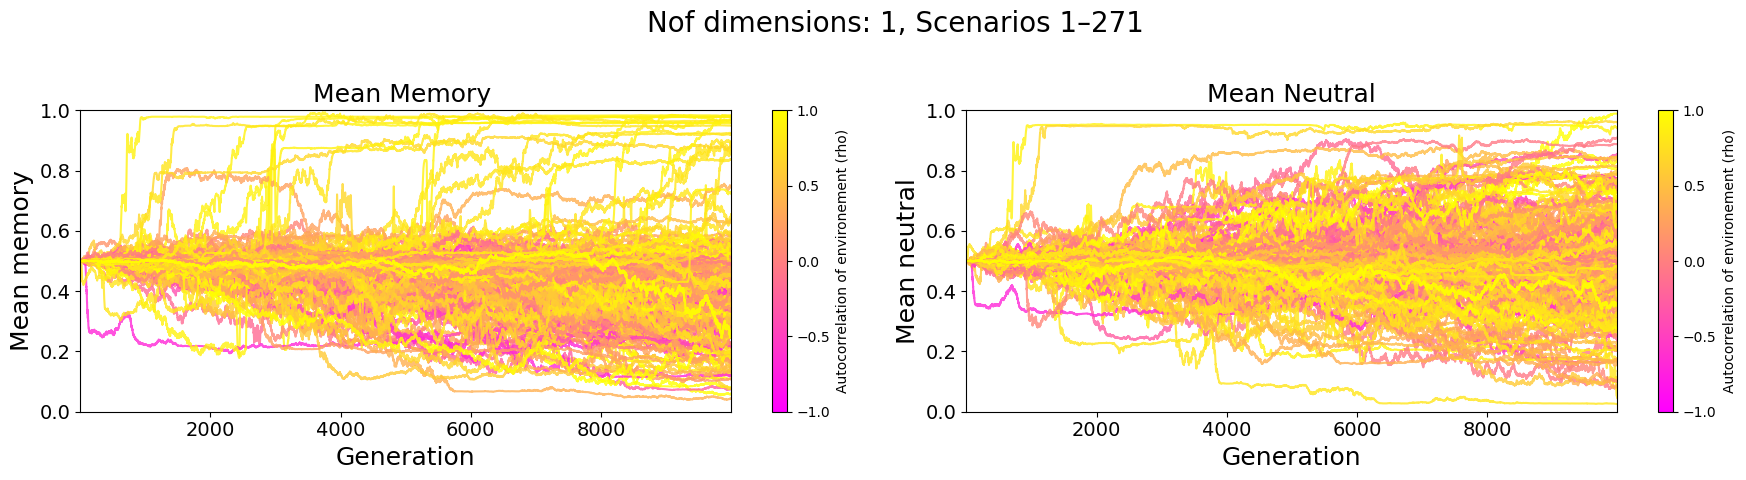

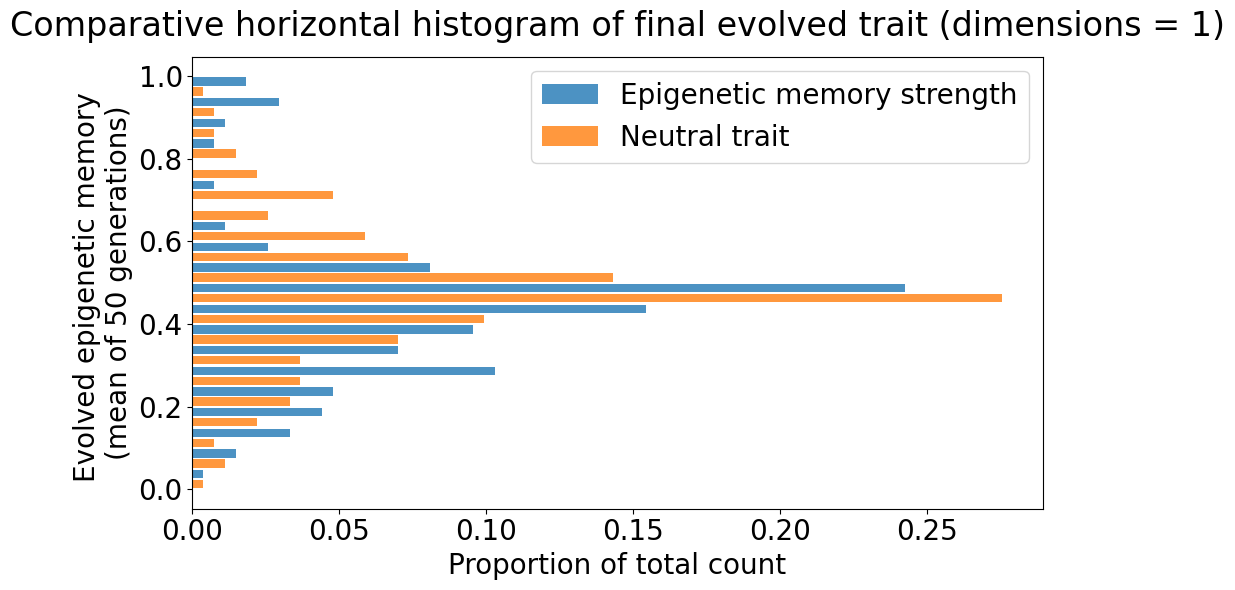

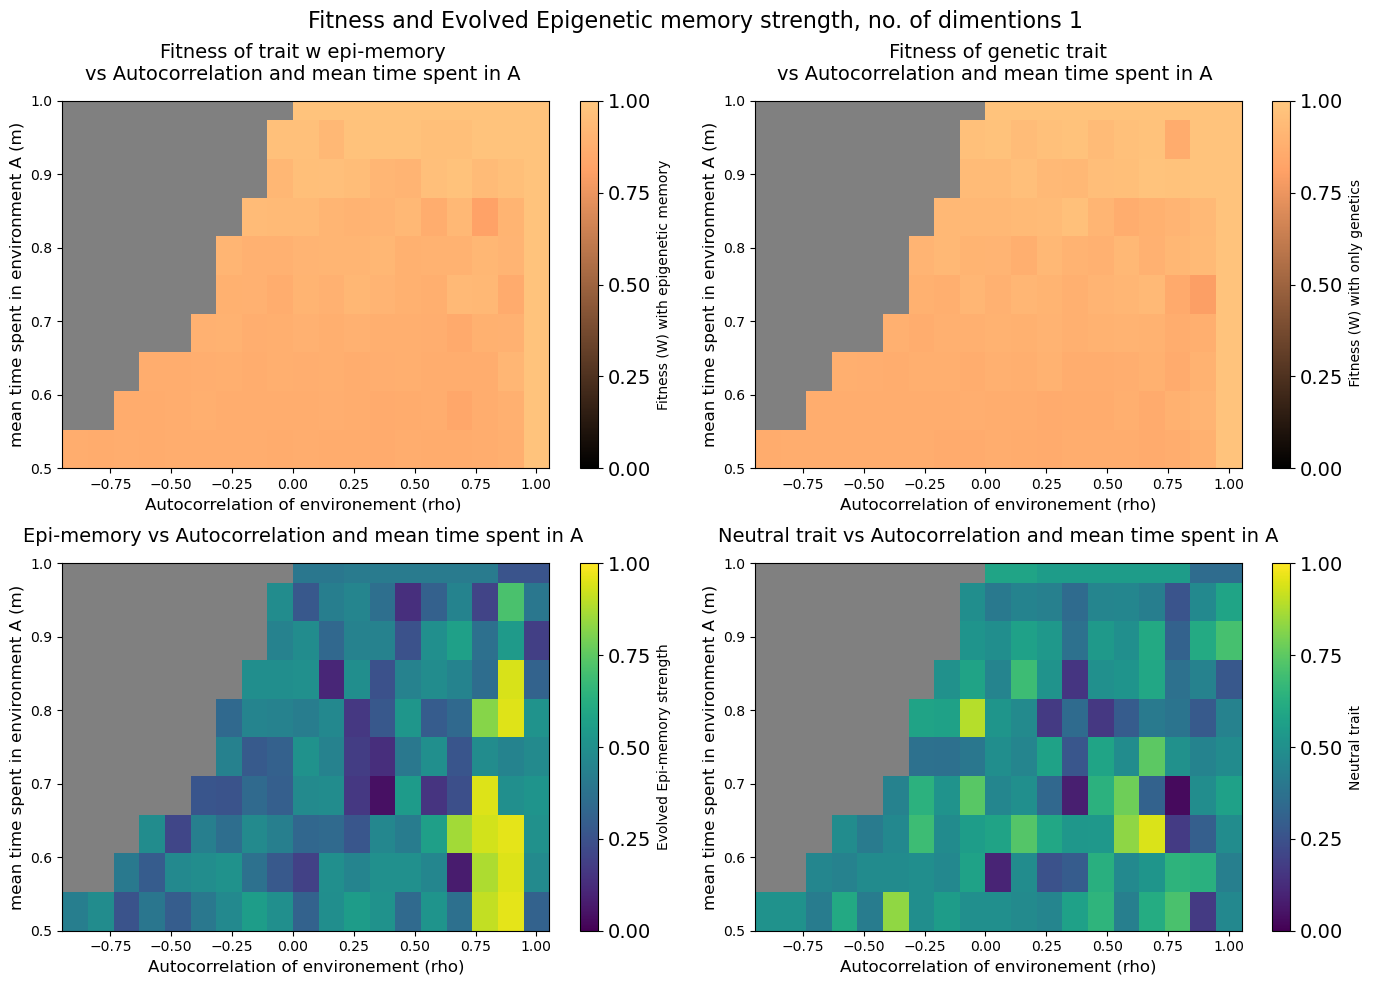

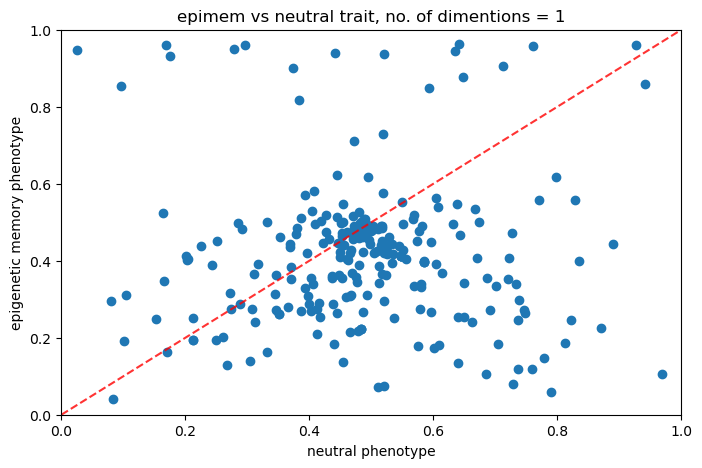

/tmp/ipykernel_31521/2396579899.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("spring")


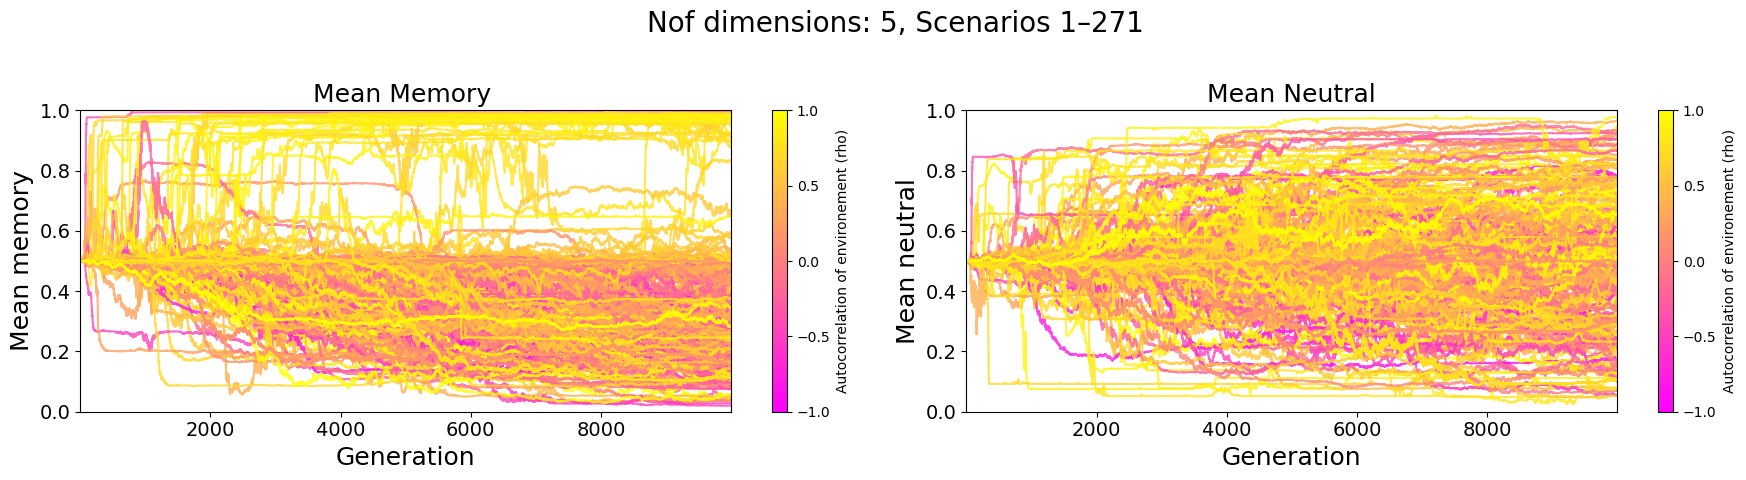

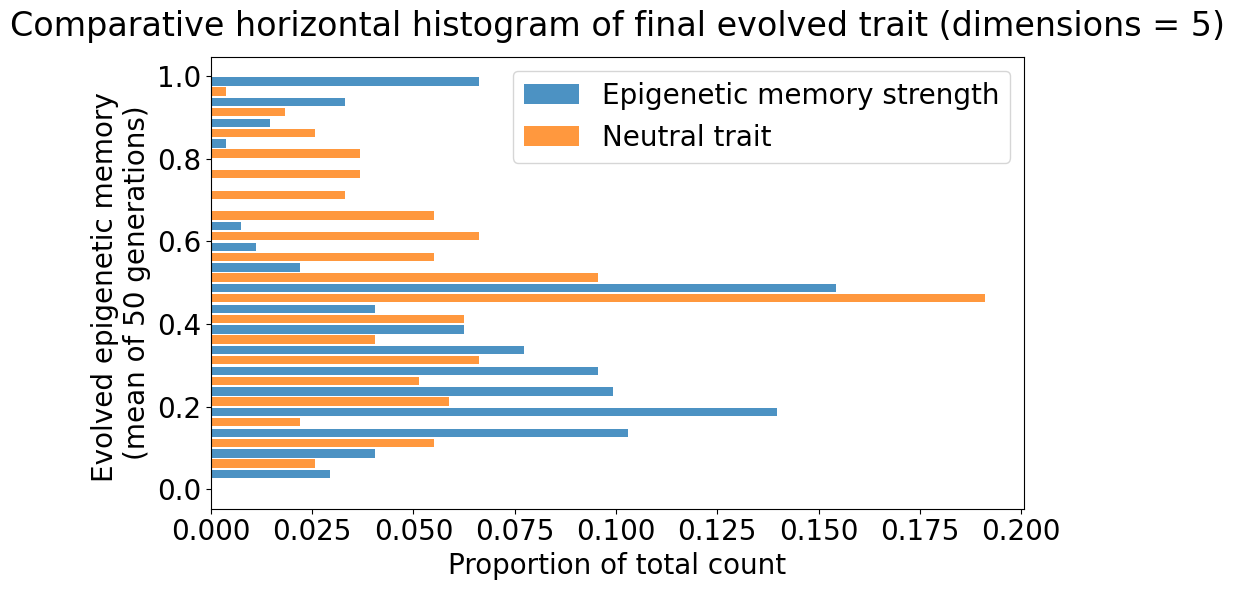

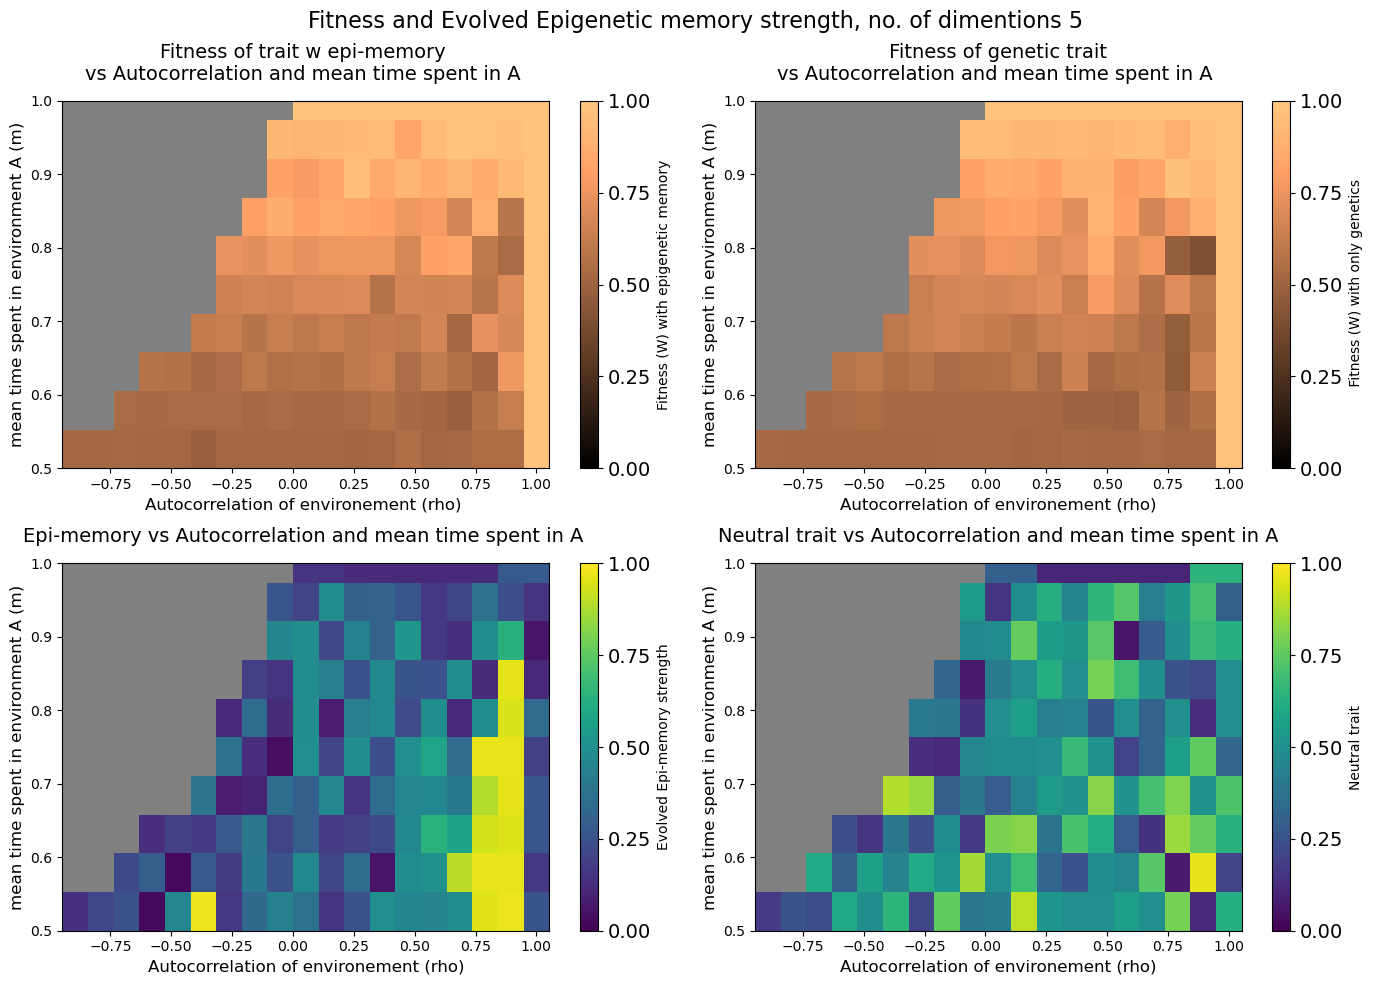

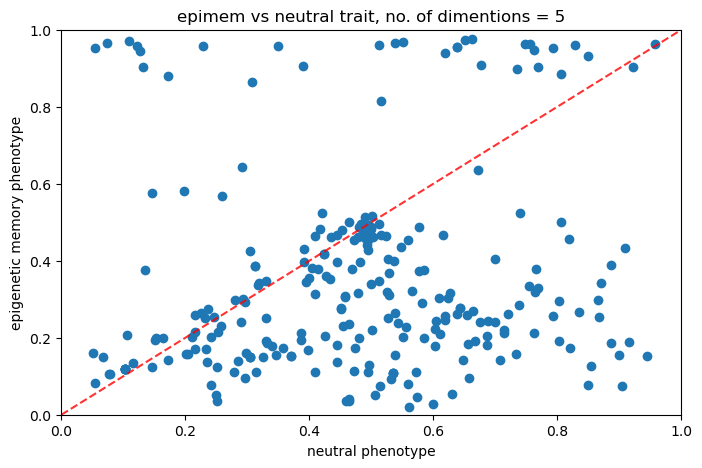

/tmp/ipykernel_31521/2396579899.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("spring")


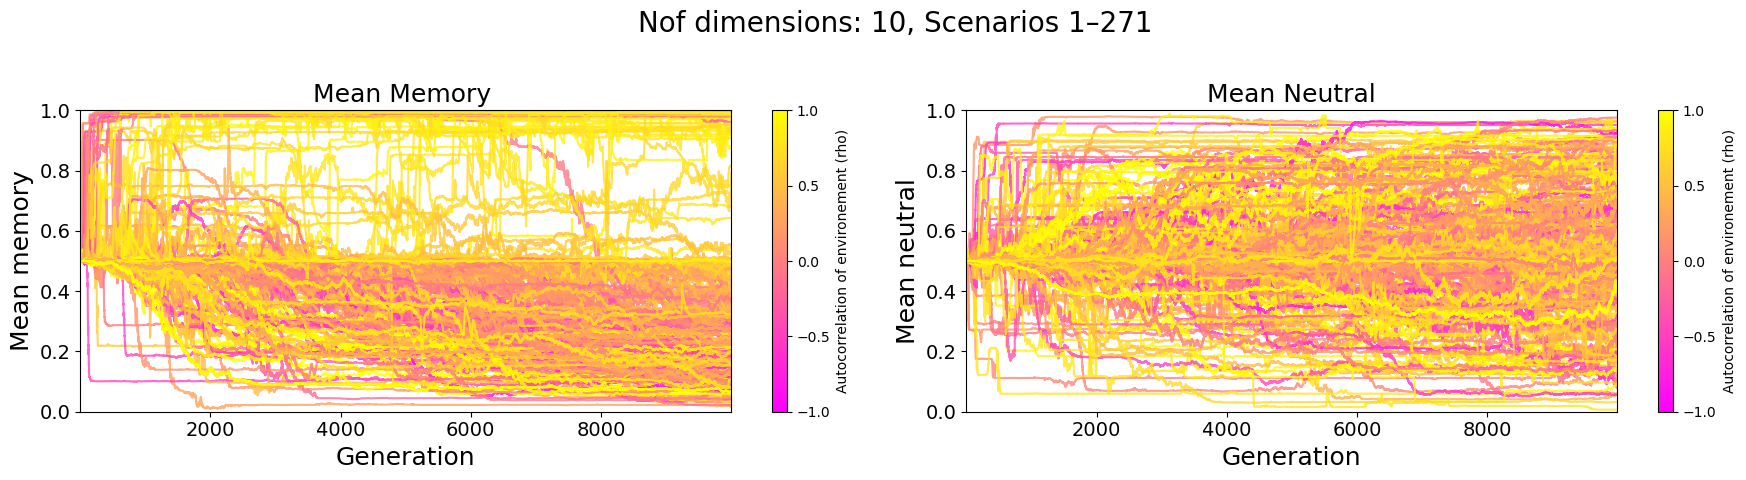

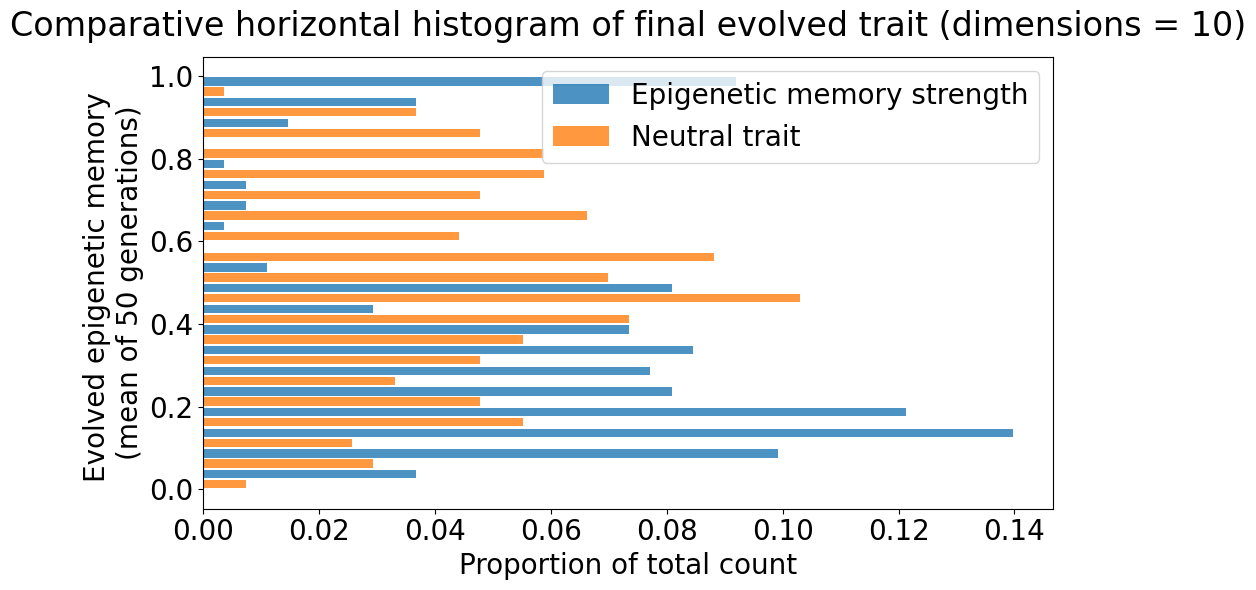

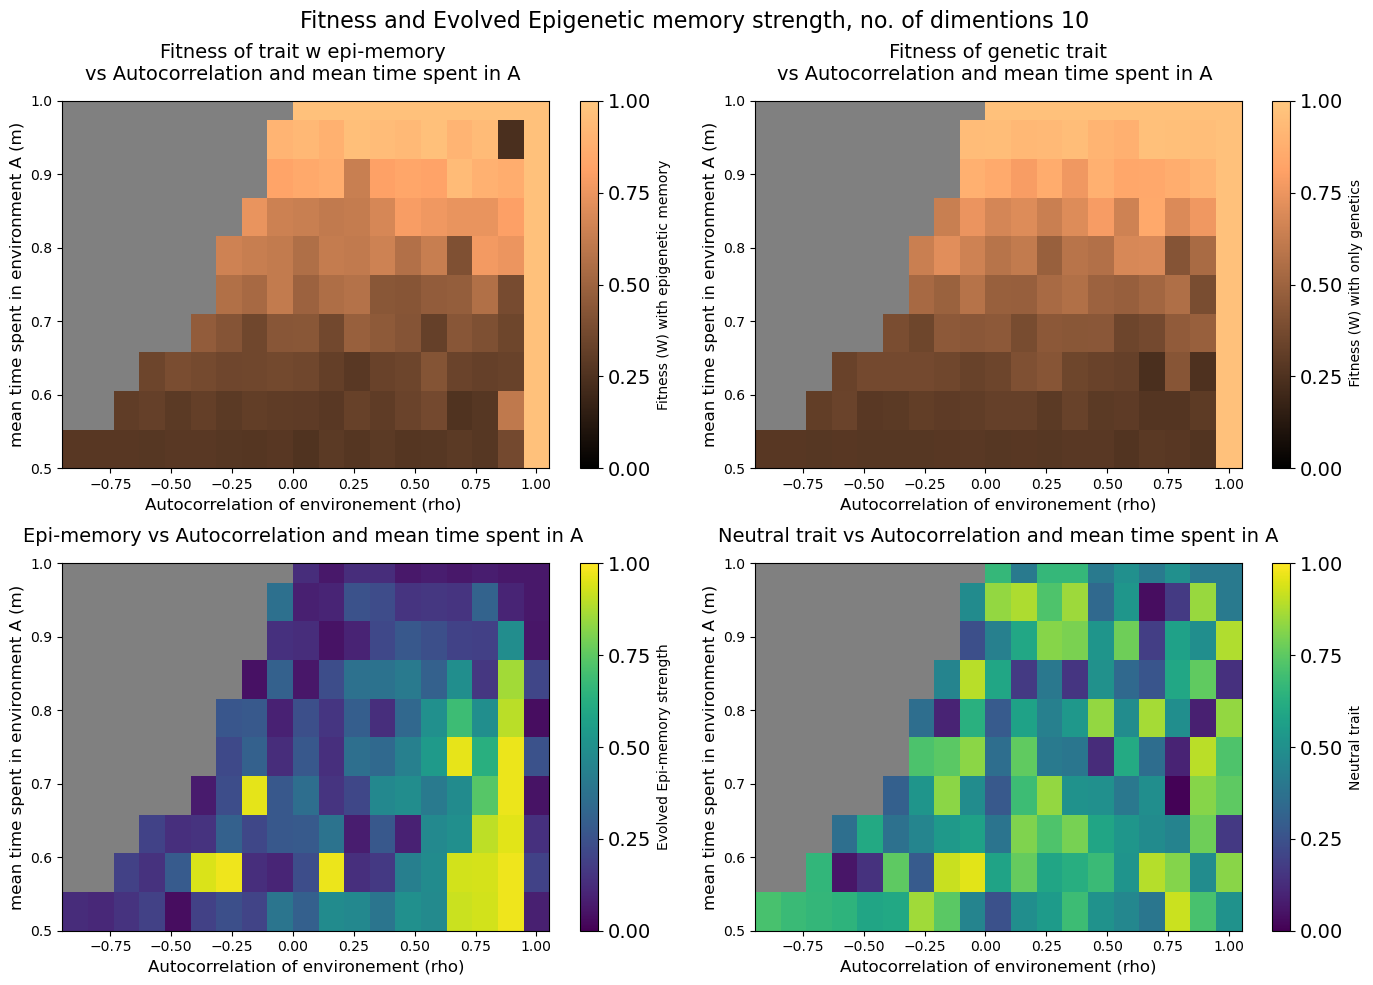

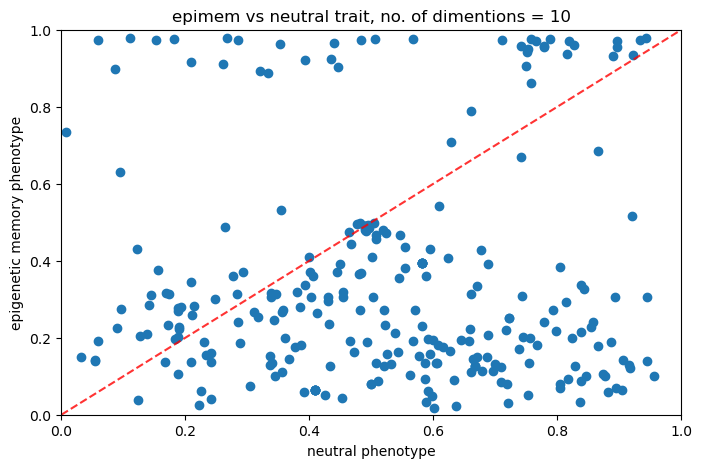

In [47]:
start = 1
concatenated_results_epi = {}
concatenated_results_gen = {}

for array_epi, array_gen in zip(sorted_epi_keys, sorted_og_keys):
    
    nof_dims = re.findall(r'\d+', array_epi)[0]
    
    
    array_name_epi = next(iter(dim_objnames_epi[array_epi].keys()))
    array_name_gen = next(iter(dim_objnames_onlygen[array_gen].keys()))

    
    
    for k in keys:
        concatenated_results_epi[k] = np.vstack([r[k] for r in dim_objnames_epi[array_epi][array_name_epi]])
        
    for k in keys:
        concatenated_results_gen[k] = np.vstack([r[k] for r in dim_objnames_onlygen[array_gen][array_name_gen]])
        
    # Extract variables
    data = concatenated_results_epi
    data_gen = concatenated_results_gen
    
    
    meanmemory_p = data['meanmemory_p'][:, :-1]
    meanneutral_p = data['meanneutral_p'][:, :-1]


    nof_scenarios = meanmemory_p.shape[0]
    maxgen = meanmemory_p.shape[1]

        # Extract rho for each scenario
    rho_values = data['rho_m_alpha_beta'][:, 0]   # one rho per scenario

    # Create figure
    fig, ax = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

    # Normalize rho range → [0, 1]
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    cmap = cm.get_cmap("spring")

    # Loop over scenarios
    for i in range(start, nof_scenarios):
        rho = rho_values[i]           # pick rho for this scenario
        color = cmap(norm(rho))       # convert rho → color

        ax[0].plot(meanmemory_p[i, :], color=color, alpha=0.8)
        ax[1].plot(meanneutral_p[i, :], color=color, alpha=0.8)

    # Axis formatting
    ax[0].set_title("Mean Memory ", fontsize=18)
    ax[0].set_ylabel("Mean memory", fontsize=18)
    ax[0].set_xlabel("Generation",  fontsize=18)
    ax[0].set_xlim(1, maxgen)
    ax[0].set_ylim(0, 1)

    ax[1].set_title("Mean Neutral", fontsize=18)
    ax[1].set_ylabel("Mean neutral",  fontsize=18)
    ax[1].set_xlabel("Generation", fontsize=18)
    ax[1].set_xlim(1, maxgen)
    ax[1].set_ylim(0, 1)
    ax[0].tick_params(axis='both', labelsize=14)
    ax[1].tick_params(axis='both', labelsize=14)
    
    #  Add a colorbar based on rho values
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # required
    cbar = fig.colorbar(sm, ax=ax[0], label="Autocorrelation of environement (rho)", ticks=[-1, -0.5, 0,  0.5,  1.0])
    cbar = fig.colorbar(sm, ax=ax[1], label="Autocorrelation of environement (rho)", ticks=[-1, -0.5, 0,  0.5,  1.0])
    fig.suptitle(f"Nof dimensions: {nof_dims}, Scenarios {start}–{nof_scenarios - 1}", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    ##########
 
    rho_ext, m_ext = np.meshgrid(data['rho_m_alpha_beta'][:,0],data['rho_m_alpha_beta'][:,1])

    df = pd.DataFrame({
        
    'rho': data['rho_m_alpha_beta'][:,0],
    'm': data['rho_m_alpha_beta'][:,1],
    'fitness':np.mean(data['meanw'][:,-50:], axis=1),
    'epi_mem_p': np.mean(data['meanmemory_p'][:,-50:], axis=1),
    'neutral_trait_p' : np.mean(data['meanneutral_p'][:,-50:], axis=1 )
    })
    
    df_gen = pd.DataFrame({
        
    'rho': data_gen['rho_m_alpha_beta'][:,0],
    'm': data_gen['rho_m_alpha_beta'][:,1],
    'fitness':np.mean(data_gen['meanw'][:,-50:], axis=1)
    })
    


    # Extract the two traits
    epi = df['epi_mem_p']
    neu = df['neutral_trait_p']

    # Define discrete bins
    bins = np.linspace(0, 1, 21)   # 20 bins
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Compute counts
    counts_epi, _ = np.histogram(epi, bins=bins)
    counts_neu, _ = np.histogram(neu, bins=bins)

    # Convert to frequencies
    freq_epi = counts_epi / counts_epi.sum()
    freq_neu = counts_neu / counts_neu.sum()

    # Width of each bar
    height = 0.02  # vertical thickness

    # Plot horizontal bars
    fig, ax = plt.subplots(figsize=(10, 6))

    # Side-by-side: shift up/down
    offset = height * 1.2

    # Epigenetic memory (upper)
    ax.barh(bin_centers + offset/2, freq_epi, height=height, color='tab:blue', alpha=0.8, label='Epigenetic memory strength')

    # Neutral trait (lower)
    ax.barh(bin_centers - offset/2, freq_neu, height=height, color='tab:orange', alpha=0.8, label='Neutral trait' )

    # Labels & formatting
    ax.set_xlabel("Proportion of total count", fontsize=20)
    ax.set_ylabel("Evolved epigenetic memory \n(mean of 50 generations)", fontsize=20)

    ax.set_title(
    f"Comparative horizontal histogram of final evolved trait (dimensions = {nof_dims})",
    fontsize=24, pad=15  
)

    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(fontsize=20)

    plt.tight_layout()
    plt.show()



    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Fitness and Evolved Epigenetic memory strength, no. of dimentions {nof_dims}", fontsize=16)
    fig.subplots_adjust(top=0.90)   # more space for the suptitle
    cmap1 = plt.cm.copper.copy()  # copy to modify safely
    cmap1.set_bad(color='gray')    # gray for masked values
    norm = mcolors.Normalize(vmin=0.0, vmax=1.0)  # consistent color range
    
    cmap2 = plt.cm.viridis.copy()  # copy to modify safely
    cmap2.set_bad(color='gray')    # gray for masked values
    norm = mcolors.Normalize(vmin=0.0, vmax=1.0)  # consistent color range
    
    
    # --- (0,0) fitness ---
    pivoted_fitness = df.pivot_table(
        index='m',
        columns='rho',
        values='fitness'
    ).sort_index().sort_index(axis=1)

    pcm1 = ax[0,0].pcolormesh(
        pivoted_fitness.columns,
        pivoted_fitness.index,
        pivoted_fitness.values,
        cmap=cmap1,
        norm=norm,
        shading='auto'
    )
    cbar1 = fig.colorbar(pcm1, ax=ax[0,0], label='Fitness (W) with epigenetic memory', 
                        ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
    cbar1.ax.tick_params(labelsize=14)

    ax[0,0].set_ylabel('mean time spent in environment A (m)', fontsize=12)
    ax[0,0].set_ylim(0.5,1)
    ax[0,0].set_xlabel('Autocorrelation of environement (rho) ', fontsize=12)
    ax[0,0].set_title('Fitness of trait w epi-memory \nvs Autocorrelation and mean time spent in A ', fontsize=14,   pad=15   )

    # --- (0,1) genetic fitness ---
    pivoted_gen = df_gen.pivot_table(
        index='m',
        columns='rho',
        values='fitness'
    ).sort_index().sort_index(axis=1)

    pcm2 = ax[0,1].pcolormesh(
        pivoted_gen.columns,
        pivoted_gen.index,
        pivoted_gen.values,
        cmap=cmap1,
        norm=norm,
        shading='auto'
    )
    cbar2 = fig.colorbar(pcm2, ax=ax[0,1], 
                        label=' Fitness (W) with only genetics',
                        ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
    cbar2.ax.tick_params(labelsize=14)

    ax[0,1].set_ylabel('mean time spent in environment A (m)', fontsize=12)
    ax[0,1].set_ylim(0.5,1)
    ax[0,1].set_xlabel('Autocorrelation of environement (rho)', fontsize=12)
    ax[0,1].set_title(' Fitness of genetic trait \nvs Autocorrelation and mean time spent in A ', fontsize=14,   pad=15   )

    # --- (1,0) epimem ---
    pivoted_epi = df.pivot_table(
        index='m',
        columns='rho',
        values='epi_mem_p'
    ).sort_index().sort_index(axis=1)

    pcm3 = ax[1,0].pcolormesh(
        pivoted_epi.columns,
        pivoted_epi.index,
        pivoted_epi.values,
        cmap=cmap2,
        norm=norm,
        shading='auto'
    )
    cbar3 = fig.colorbar(pcm3, ax=ax[1,0], label=r'Evolved Epi-memory strength',
                        ticks=[0, 0.25, 0.5, 0.75, 1.0])
    cbar3.ax.tick_params(labelsize=14)

    ax[1,0].set_ylabel('mean time spent in environment A (m)', fontsize=12)
    ax[1,0].set_ylim(0.5,1)
    ax[1,0].set_xlabel('Autocorrelation of environement (rho)', fontsize=12)
    ax[1,0].set_title('Epi-memory vs Autocorrelation and mean time spent in A ', fontsize=14,   pad=15   )

    # --- (1,1) neutral ---
    pivoted_neutral = df.pivot_table(
        index='m',
        columns='rho',
        values='neutral_trait_p'
    ).sort_index().sort_index(axis=1)

    pcm4 = ax[1,1].pcolormesh(
        pivoted_neutral.columns,
        pivoted_neutral.index,
        pivoted_neutral.values,
        cmap=cmap2,
        norm=norm,
        shading='auto'
    )
    cbar4 = fig.colorbar(pcm4, ax=ax[1,1], label='Neutral trait',
                        ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
    cbar4.ax.tick_params(labelsize=14)

    ax[1,1].set_ylabel('mean time spent in environment A (m)', fontsize=12)
    ax[1,1].set_ylim(0.5,1)
    ax[1,1].set_xlabel('Autocorrelation of environement (rho)', fontsize=12)
    ax[1,1].set_title('Neutral trait vs Autocorrelation and mean time spent in A', fontsize=14,  pad=15   )
    
    

    plt.tight_layout()
    plt.show()
    
    
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.scatter( df['neutral_trait_p'], df['epi_mem_p'] )
    plt.title(f"epimem vs neutral trait, no. of dimentions = {nof_dims}")
    plt.plot((0,1), (0,1), 'r--', alpha=0.8)  # red dashed line
    
    plt.ylabel("epigenetic memory phenotype")
    plt.xlabel("neutral phenotype")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()



In [49]:
dim_objnames_epi = {}
folder_path = '/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/long_time/start3/epi'
for i, filename in enumerate(sorted(os.listdir(folder_path))):
    if filename.endswith(".pkl"):
        
        file_path = os.path.join(folder_path, filename)
        print(f"Loading: {filename}")
        
        # Load the pickle file
        with open(file_path, "rb") as file:
            data = pickle.load(file)
            
        nof_dims = re.search(r'_dims(\d+)', filename).group(1)

        
        name= f'epi_{nof_dims}'
        dim_objnames_epi[name] = data
        
        print(f"Loaded {filename} into {name}")
        
dim_objnames_onlygen = {}
folder_path = '/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/long_time/start3/onlygen'
for i, filename in enumerate(sorted(os.listdir(folder_path))):
    if filename.endswith(".pkl"):
        
        file_path = os.path.join(folder_path, filename)
        print(f"Loading: {filename}")
        
        # Load the pickle file
        with open(file_path, "rb") as file:
            data = pickle.load(file)
            
        nof_dims = re.search(r'_dims(\d+)', filename).group(1)

        
        name= f'onlygen_{nof_dims}'
        dim_objnames_onlygen[name] = data
        
        print(f"Loaded {filename} into {name}")

Loading: gens10000_start3.0_dims1.pkl
Loaded gens10000_start3.0_dims1.pkl into epi_1
Loading: gens10000_start3.0_dims10.pkl
Loaded gens10000_start3.0_dims10.pkl into epi_10
Loading: gens10000_start3.0_dims5.pkl
Loaded gens10000_start3.0_dims5.pkl into epi_5
Loading: gens10000_start3.0_dims10_onlygen.pkl
Loaded gens10000_start3.0_dims10_onlygen.pkl into onlygen_10
Loading: gens10000_start3.0_dims1_onlygen.pkl
Loaded gens10000_start3.0_dims1_onlygen.pkl into onlygen_1
Loading: gens10000_start3.0_dims5_onlygen.pkl
Loaded gens10000_start3.0_dims5_onlygen.pkl into onlygen_5


In [29]:

sorted_epi_keys = sorted(dim_objnames_epi.keys(), key=lambda x: int(re.findall(r'\d+', x)[0]))
sorted_og_keys = sorted(dim_objnames_onlygen.keys(), key=lambda x: int(re.findall(r'\d+', x)[0]))
# Get all keys 
keys = dim_objnames_epi[sorted_epi_keys[0]]['results_array_1'][0].keys()
keys

dict_keys(['maxgen_popsize', 'rho_m_alpha_beta', 'meanw', 'meanmemory_g', 'meanmemory_p', 'meanneutral_g', 'meanneutral_p', 'mean_geno'])

In [14]:
dim_objnames_epi[sorted_epi_keys[0]]['results_array_1'][0]['rho_m_alpha_beta'].shape

(4,)

In [5]:
cmap = plt.cm.inferno.copy()  # copy to modify safely
cmap.set_bad(color='gray')    # gray for masked values
norm = mcolors.Normalize(vmin=0.0, vmax=1.0)  # consistent color range

In [ ]:
concatenated_results_epi = {}
array_name_epi = next(iter(dim_objnames_epi[sorted_epi_keys[0]].keys()))
for k in keys:
    concatenated_results_epi[k] = np.vstack([r[k] for r in dim_objnames_epi[sorted_epi_keys[0]][array_name_epi]])
    


In [25]:

colors = cmap(np.linspace(0, 1, concatenated_results_epi['rho_m_alpha_beta'].shape[0]))


In [27]:
for i, no, color in zip(range(start, nof_scenarios), enumerate(colors)): 
         
        # Left plot: mean memory
        ax[0].plot(meanmemory_p[i, :], color =color)

        # Right plot: mean neutral
        ax[1].plot(meanneutral_p[i, :], color = color )

ValueError: not enough values to unpack (expected 3, got 2)

/tmp/ipykernel_31521/2396579899.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("spring")


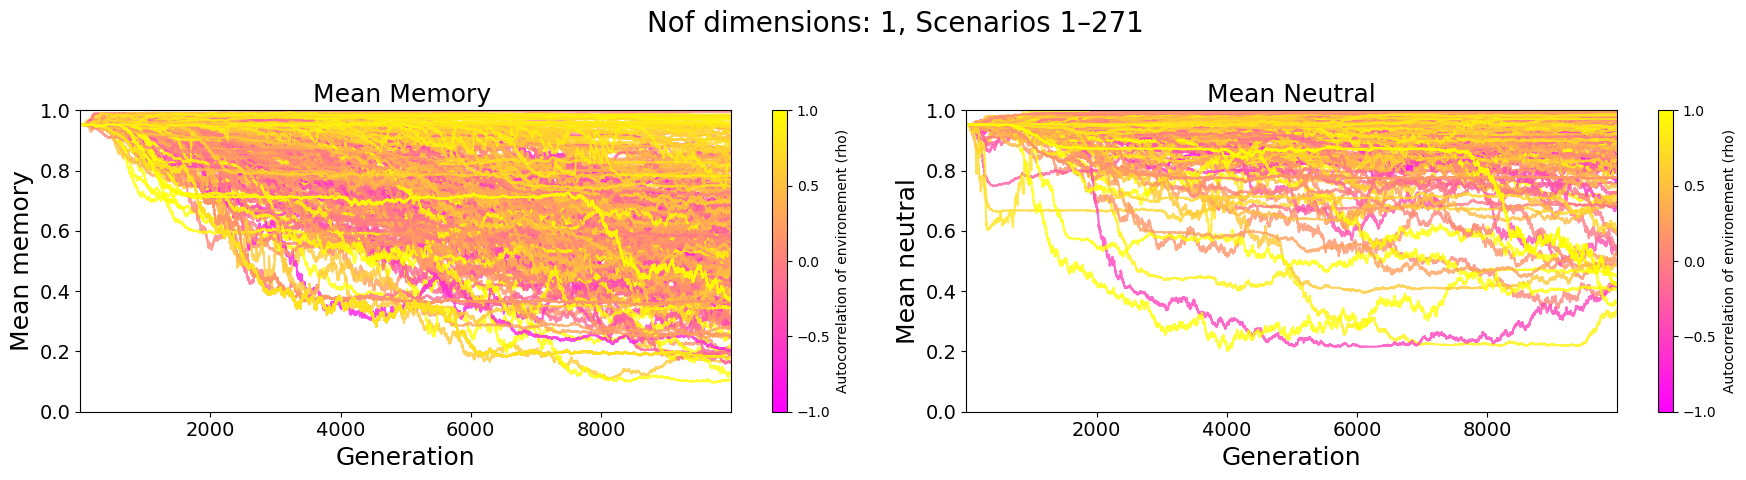

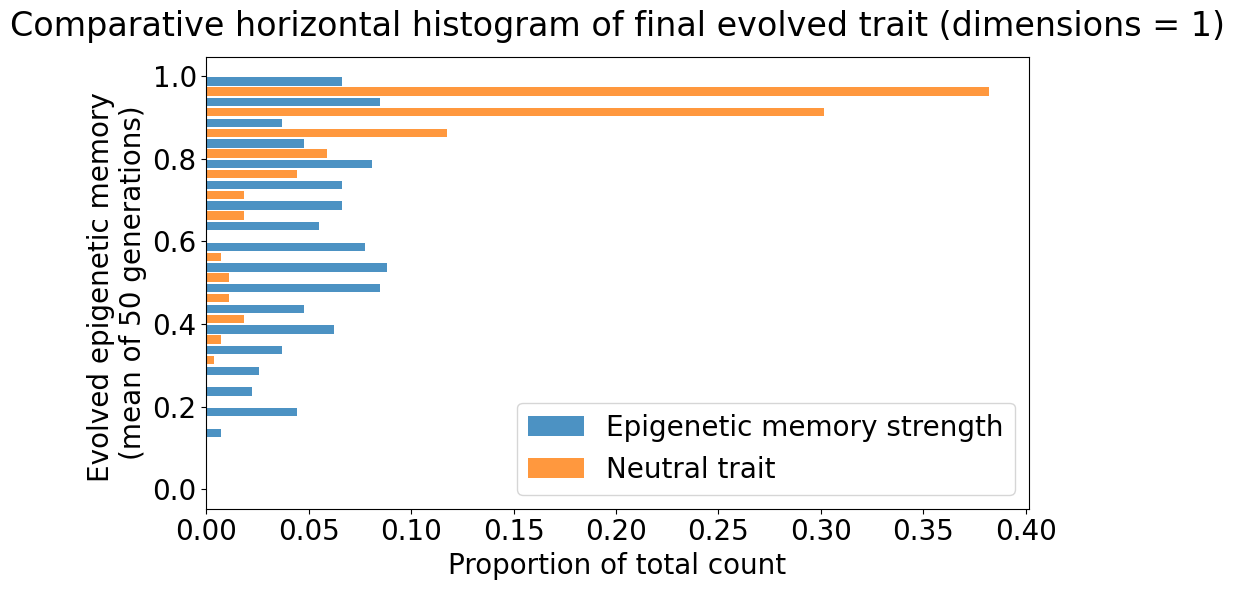

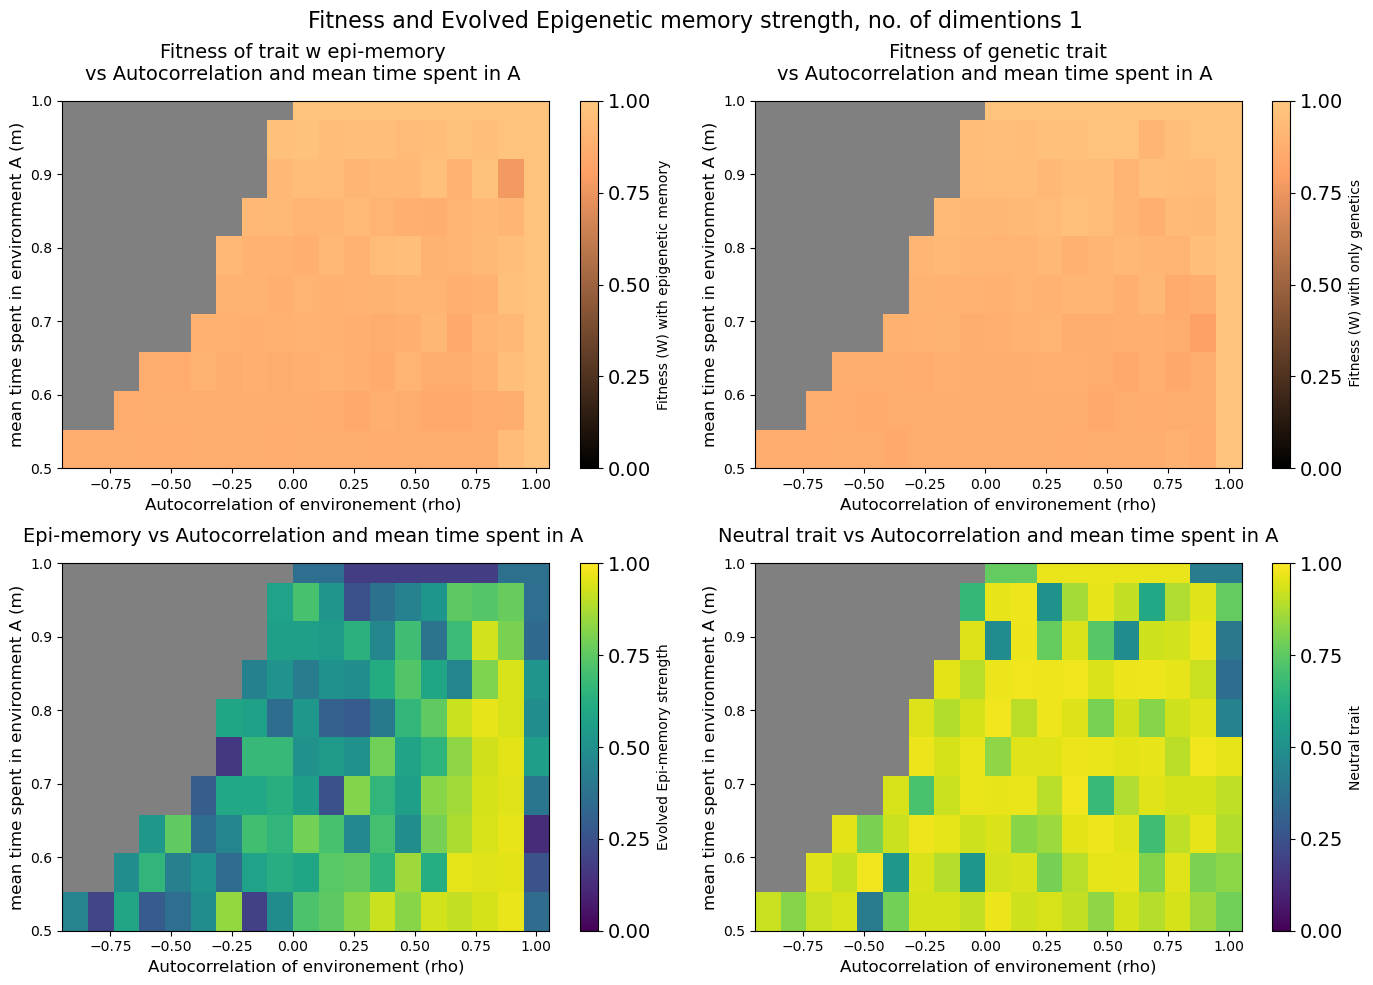

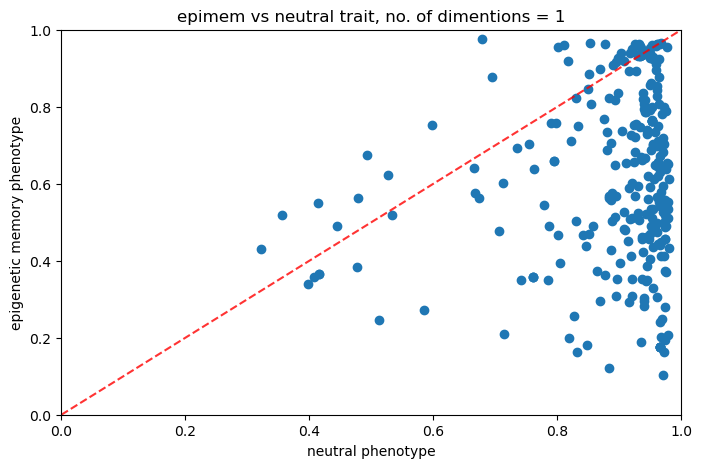

/tmp/ipykernel_31521/2396579899.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("spring")


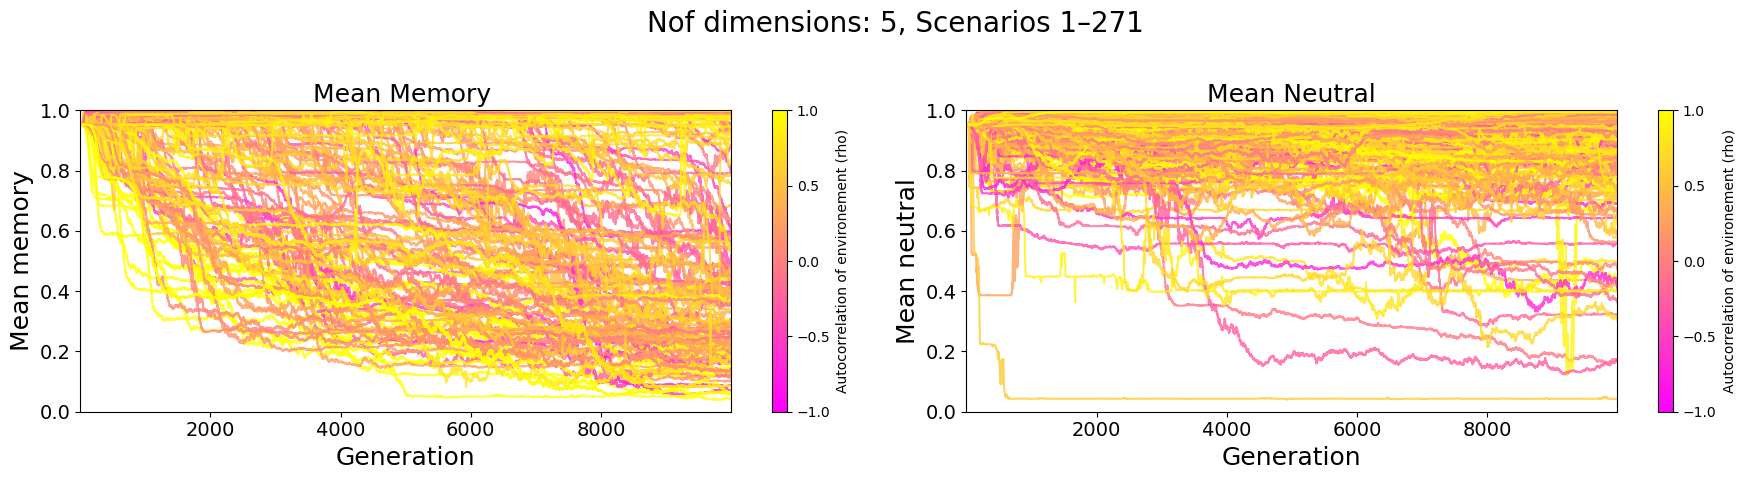

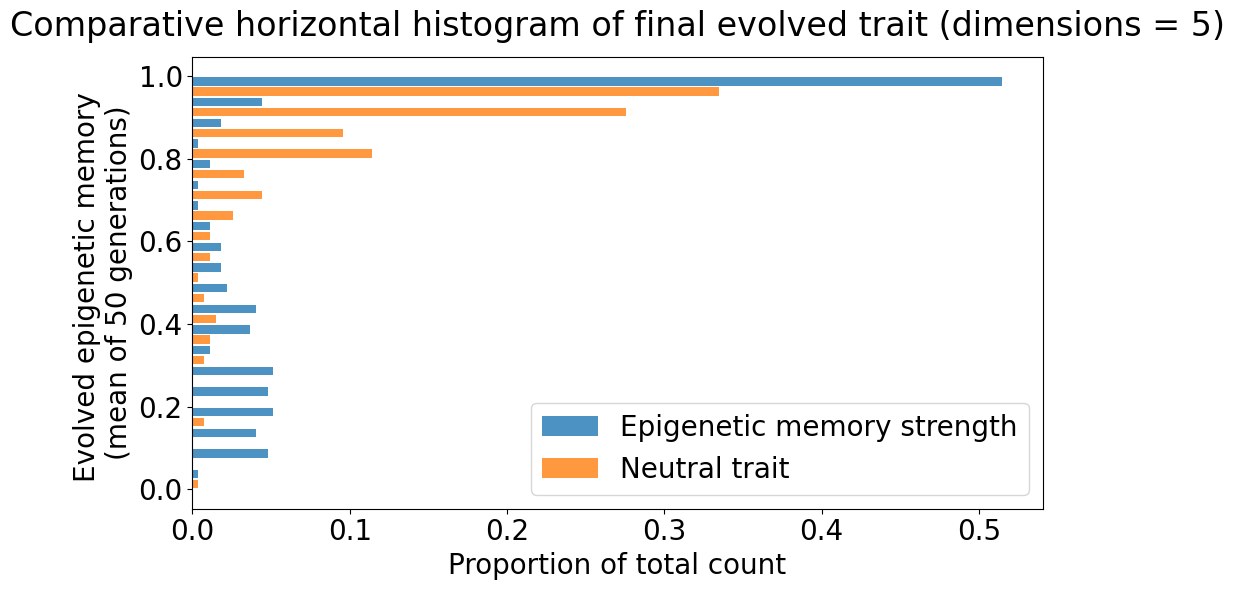

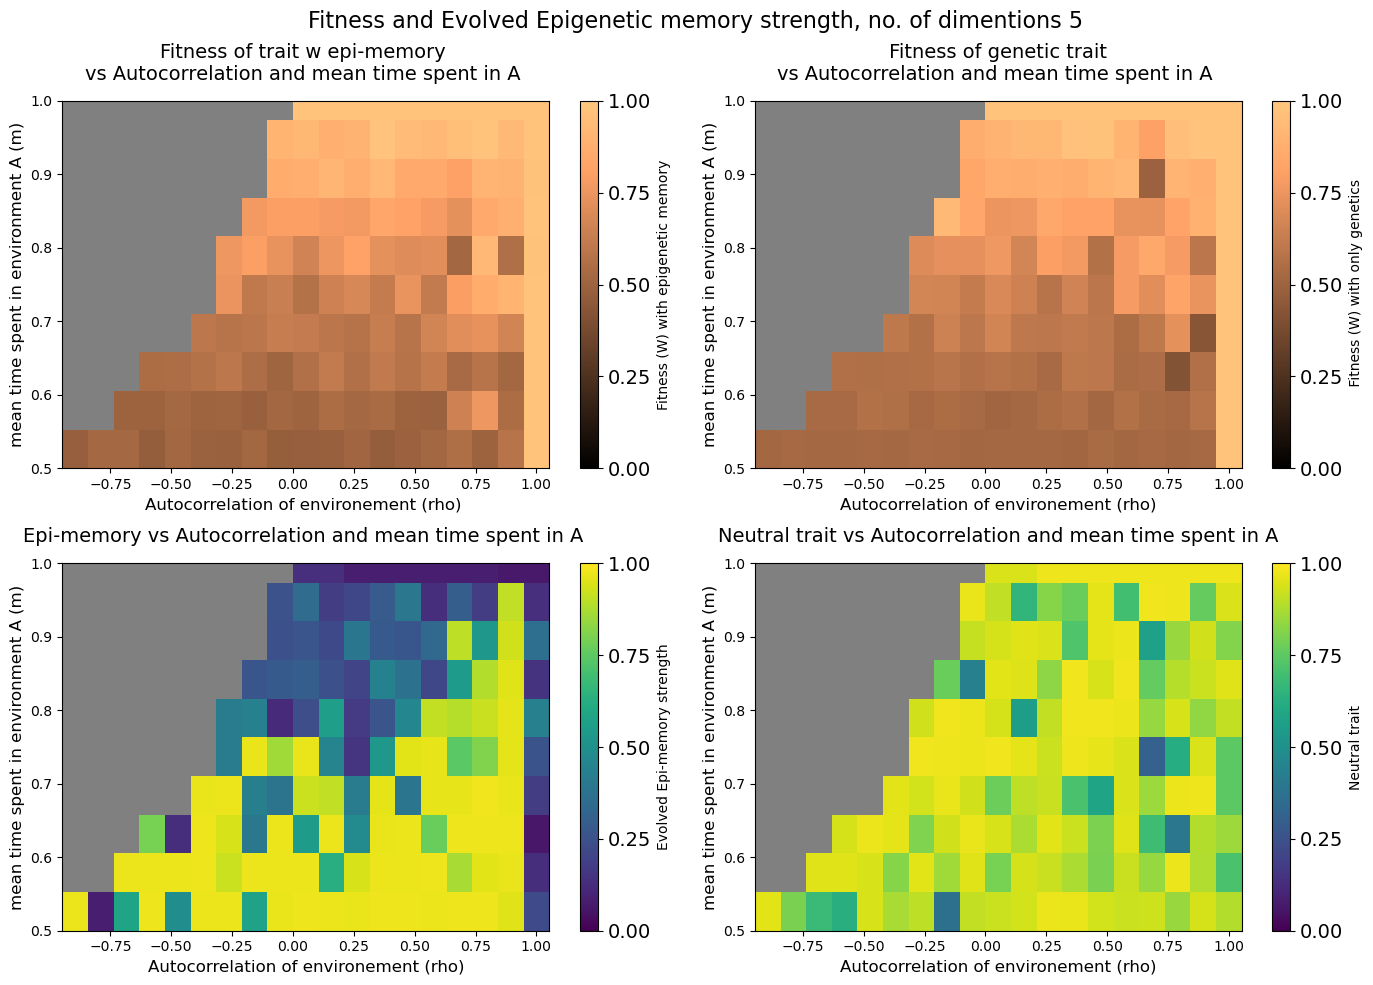

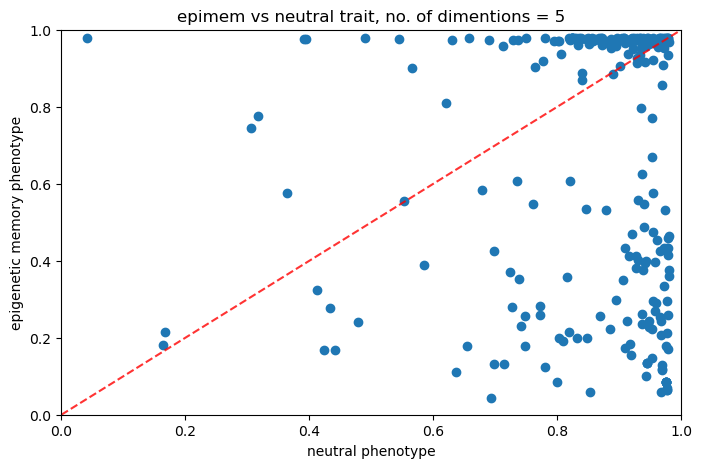

/tmp/ipykernel_31521/2396579899.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("spring")


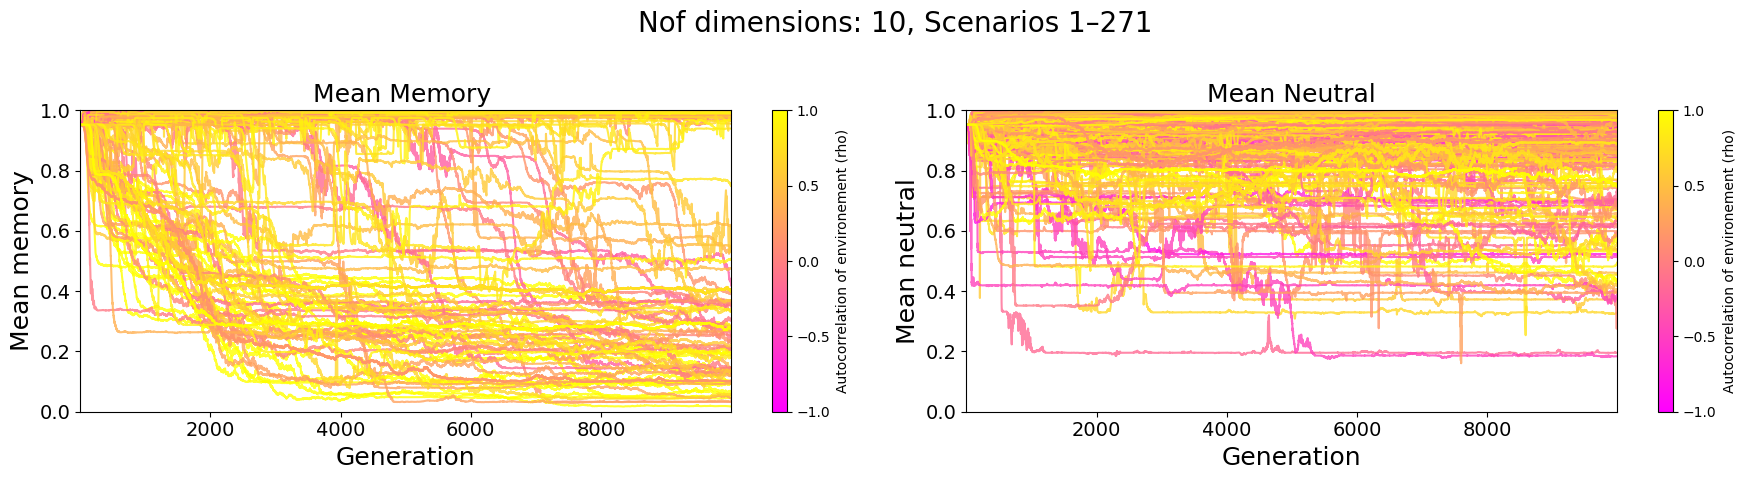

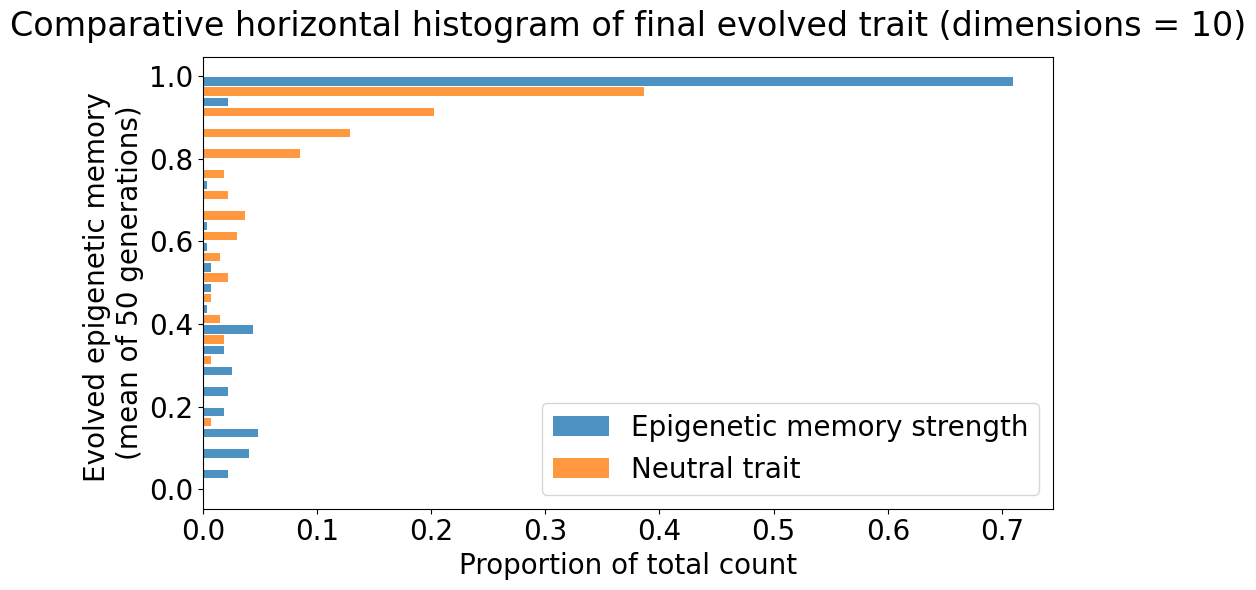

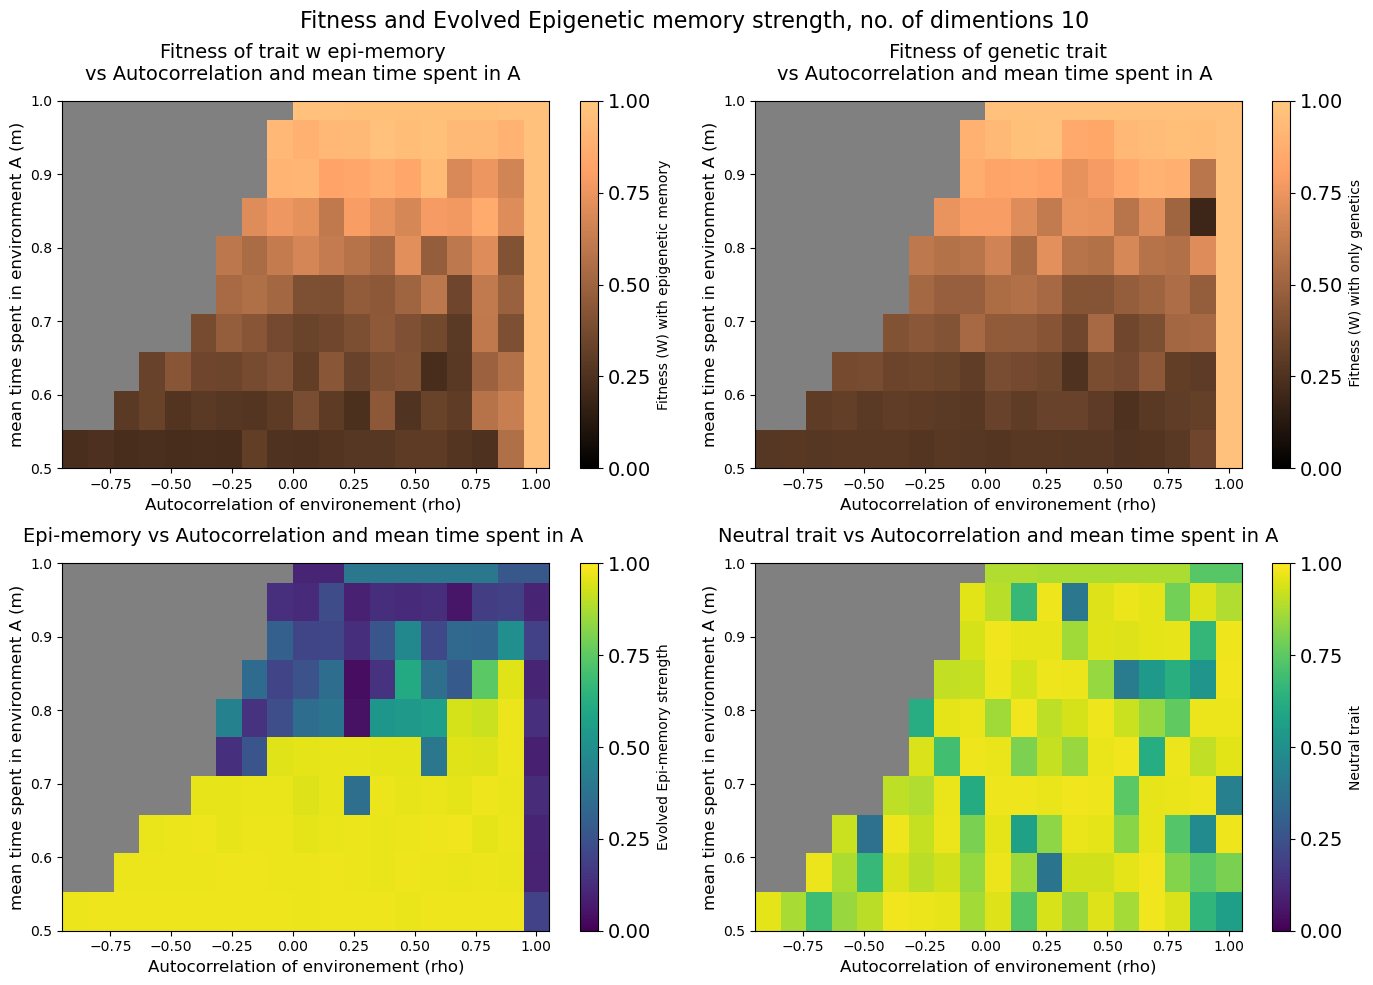

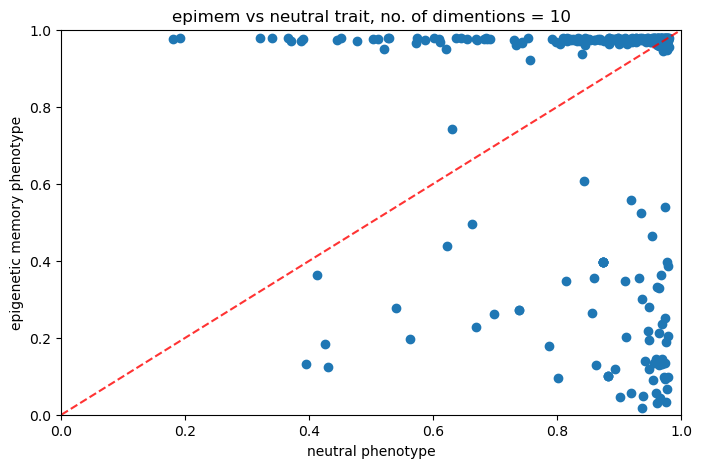

In [50]:
start = 1
concatenated_results_epi = {}
concatenated_results_gen = {}

for array_epi, array_gen in zip(sorted_epi_keys, sorted_og_keys):
    
    nof_dims = re.findall(r'\d+', array_epi)[0]
    
    
    array_name_epi = next(iter(dim_objnames_epi[array_epi].keys()))
    array_name_gen = next(iter(dim_objnames_onlygen[array_gen].keys()))

    
    
    for k in keys:
        concatenated_results_epi[k] = np.vstack([r[k] for r in dim_objnames_epi[array_epi][array_name_epi]])
        
    for k in keys:
        concatenated_results_gen[k] = np.vstack([r[k] for r in dim_objnames_onlygen[array_gen][array_name_gen]])
        
    # Extract variables
    data = concatenated_results_epi
    data_gen = concatenated_results_gen
    
    
    meanmemory_p = data['meanmemory_p'][:, :-1]
    meanneutral_p = data['meanneutral_p'][:, :-1]


    nof_scenarios = meanmemory_p.shape[0]
    maxgen = meanmemory_p.shape[1]

        # Extract rho for each scenario
    rho_values = data['rho_m_alpha_beta'][:, 0]   # one rho per scenario

    # Create figure
    fig, ax = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

    # Normalize rho range → [0, 1]
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    cmap = cm.get_cmap("spring")

    # Loop over scenarios
    for i in range(start, nof_scenarios):
        rho = rho_values[i]           # pick rho for this scenario
        color = cmap(norm(rho))       # convert rho → color

        ax[0].plot(meanmemory_p[i, :], color=color, alpha=0.8)
        ax[1].plot(meanneutral_p[i, :], color=color, alpha=0.8)

    # Axis formatting
    ax[0].set_title("Mean Memory ", fontsize=18)
    ax[0].set_ylabel("Mean memory", fontsize=18)
    ax[0].set_xlabel("Generation",  fontsize=18)
    ax[0].set_xlim(1, maxgen)
    ax[0].set_ylim(0, 1)

    ax[1].set_title("Mean Neutral", fontsize=18)
    ax[1].set_ylabel("Mean neutral",  fontsize=18)
    ax[1].set_xlabel("Generation", fontsize=18)
    ax[1].set_xlim(1, maxgen)
    ax[1].set_ylim(0, 1)
    ax[0].tick_params(axis='both', labelsize=14)
    ax[1].tick_params(axis='both', labelsize=14)
    
    #  Add a colorbar based on rho values
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # required
    cbar = fig.colorbar(sm, ax=ax[0], label="Autocorrelation of environement (rho)", ticks=[-1, -0.5, 0,  0.5,  1.0])
    cbar = fig.colorbar(sm, ax=ax[1], label="Autocorrelation of environement (rho)", ticks=[-1, -0.5, 0,  0.5,  1.0])
    fig.suptitle(f"Nof dimensions: {nof_dims}, Scenarios {start}–{nof_scenarios - 1}", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    ##########
 
    rho_ext, m_ext = np.meshgrid(data['rho_m_alpha_beta'][:,0],data['rho_m_alpha_beta'][:,1])

    df = pd.DataFrame({
        
    'rho': data['rho_m_alpha_beta'][:,0],
    'm': data['rho_m_alpha_beta'][:,1],
    'fitness':np.mean(data['meanw'][:,-50:], axis=1),
    'epi_mem_p': np.mean(data['meanmemory_p'][:,-50:], axis=1),
    'neutral_trait_p' : np.mean(data['meanneutral_p'][:,-50:], axis=1 )
    })
    
    df_gen = pd.DataFrame({
        
    'rho': data_gen['rho_m_alpha_beta'][:,0],
    'm': data_gen['rho_m_alpha_beta'][:,1],
    'fitness':np.mean(data_gen['meanw'][:,-50:], axis=1)
    })
    


    # Extract the two traits
    epi = df['epi_mem_p']
    neu = df['neutral_trait_p']

    # Define discrete bins
    bins = np.linspace(0, 1, 21)   # 20 bins
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Compute counts
    counts_epi, _ = np.histogram(epi, bins=bins)
    counts_neu, _ = np.histogram(neu, bins=bins)

    # Convert to frequencies
    freq_epi = counts_epi / counts_epi.sum()
    freq_neu = counts_neu / counts_neu.sum()

    # Width of each bar
    height = 0.02  # vertical thickness

    # Plot horizontal bars
    fig, ax = plt.subplots(figsize=(10, 6))

    # Side-by-side: shift up/down
    offset = height * 1.2

    # Epigenetic memory (upper)
    ax.barh(bin_centers + offset/2, freq_epi, height=height, color='tab:blue', alpha=0.8, label='Epigenetic memory strength')

    # Neutral trait (lower)
    ax.barh(bin_centers - offset/2, freq_neu, height=height, color='tab:orange', alpha=0.8, label='Neutral trait' )

    # Labels & formatting
    ax.set_xlabel("Proportion of total count", fontsize=20)
    ax.set_ylabel("Evolved epigenetic memory \n(mean of 50 generations)", fontsize=20)

    ax.set_title(
    f"Comparative horizontal histogram of final evolved trait (dimensions = {nof_dims})",
    fontsize=24, pad=15  
)

    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(fontsize=20)

    plt.tight_layout()
    plt.show()



    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Fitness and Evolved Epigenetic memory strength, no. of dimentions {nof_dims}", fontsize=16)
    fig.subplots_adjust(top=0.90)   # more space for the suptitle
    cmap1 = plt.cm.copper.copy()  # copy to modify safely
    cmap1.set_bad(color='gray')    # gray for masked values
    norm = mcolors.Normalize(vmin=0.0, vmax=1.0)  # consistent color range
    
    cmap2 = plt.cm.viridis.copy()  # copy to modify safely
    cmap2.set_bad(color='gray')    # gray for masked values
    norm = mcolors.Normalize(vmin=0.0, vmax=1.0)  # consistent color range
    
    
    # --- (0,0) fitness ---
    pivoted_fitness = df.pivot_table(
        index='m',
        columns='rho',
        values='fitness'
    ).sort_index().sort_index(axis=1)

    pcm1 = ax[0,0].pcolormesh(
        pivoted_fitness.columns,
        pivoted_fitness.index,
        pivoted_fitness.values,
        cmap=cmap1,
        norm=norm,
        shading='auto'
    )
    cbar1 = fig.colorbar(pcm1, ax=ax[0,0], label='Fitness (W) with epigenetic memory', 
                        ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
    cbar1.ax.tick_params(labelsize=14)

    ax[0,0].set_ylabel('mean time spent in environment A (m)', fontsize=12)
    ax[0,0].set_ylim(0.5,1)
    ax[0,0].set_xlabel('Autocorrelation of environement (rho) ', fontsize=12)
    ax[0,0].set_title('Fitness of trait w epi-memory \nvs Autocorrelation and mean time spent in A ', fontsize=14,   pad=15   )

    # --- (0,1) genetic fitness ---
    pivoted_gen = df_gen.pivot_table(
        index='m',
        columns='rho',
        values='fitness'
    ).sort_index().sort_index(axis=1)

    pcm2 = ax[0,1].pcolormesh(
        pivoted_gen.columns,
        pivoted_gen.index,
        pivoted_gen.values,
        cmap=cmap1,
        norm=norm,
        shading='auto'
    )
    cbar2 = fig.colorbar(pcm2, ax=ax[0,1], 
                        label=' Fitness (W) with only genetics',
                        ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
    cbar2.ax.tick_params(labelsize=14)

    ax[0,1].set_ylabel('mean time spent in environment A (m)', fontsize=12)
    ax[0,1].set_ylim(0.5,1)
    ax[0,1].set_xlabel('Autocorrelation of environement (rho)', fontsize=12)
    ax[0,1].set_title(' Fitness of genetic trait \nvs Autocorrelation and mean time spent in A ', fontsize=14,   pad=15   )

    # --- (1,0) epimem ---
    pivoted_epi = df.pivot_table(
        index='m',
        columns='rho',
        values='epi_mem_p'
    ).sort_index().sort_index(axis=1)

    pcm3 = ax[1,0].pcolormesh(
        pivoted_epi.columns,
        pivoted_epi.index,
        pivoted_epi.values,
        cmap=cmap2,
        norm=norm,
        shading='auto'
    )
    cbar3 = fig.colorbar(pcm3, ax=ax[1,0], label=r'Evolved Epi-memory strength',
                        ticks=[0, 0.25, 0.5, 0.75, 1.0])
    cbar3.ax.tick_params(labelsize=14)

    ax[1,0].set_ylabel('mean time spent in environment A (m)', fontsize=12)
    ax[1,0].set_ylim(0.5,1)
    ax[1,0].set_xlabel('Autocorrelation of environement (rho)', fontsize=12)
    ax[1,0].set_title('Epi-memory vs Autocorrelation and mean time spent in A ', fontsize=14,   pad=15   )

    # --- (1,1) neutral ---
    pivoted_neutral = df.pivot_table(
        index='m',
        columns='rho',
        values='neutral_trait_p'
    ).sort_index().sort_index(axis=1)

    pcm4 = ax[1,1].pcolormesh(
        pivoted_neutral.columns,
        pivoted_neutral.index,
        pivoted_neutral.values,
        cmap=cmap2,
        norm=norm,
        shading='auto'
    )
    cbar4 = fig.colorbar(pcm4, ax=ax[1,1], label='Neutral trait',
                        ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
    cbar4.ax.tick_params(labelsize=14)

    ax[1,1].set_ylabel('mean time spent in environment A (m)', fontsize=12)
    ax[1,1].set_ylim(0.5,1)
    ax[1,1].set_xlabel('Autocorrelation of environement (rho)', fontsize=12)
    ax[1,1].set_title('Neutral trait vs Autocorrelation and mean time spent in A', fontsize=14,  pad=15   )
    
    

    plt.tight_layout()
    plt.show()
    
    
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.scatter( df['neutral_trait_p'], df['epi_mem_p'] )
    plt.title(f"epimem vs neutral trait, no. of dimentions = {nof_dims}")
    plt.plot((0,1), (0,1), 'r--', alpha=0.8)  # red dashed line
    
    plt.ylabel("epigenetic memory phenotype")
    plt.xlabel("neutral phenotype")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()



In [139]:
file='/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/long_time/gens5k_0.001mutrate_0start_onlygen.pkl'

with open(file, 'wb') as f:
    pickle.dump(results_array, f)

In [67]:
file_path = "/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/long_time/start0/onlygen/gens10000_start0.0_dims10_onlygen.pkl"

# Open and load the file
with open(file_path, 'rb') as f:
    data = pickle.load(f)

UnpicklingError: pickle data was truncated